In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('train.csv', sep = ',')
X = df.loc[:,'var_0':'var_199']
Y = df.loc[:,'target']
X.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [4]:
fraud_index = np.where(Y==1)
honest_index = np.where(Y==0)
fraud = X.loc[fraud_index]
honest = X.loc[honest_index]

In [5]:
yh = Y.loc[honest_index]
yf = Y.loc[fraud_index]

In [6]:
h_train, h_test, hy_train, hy_test = train_test_split(honest, yh,test_size=0.3,
                                                      random_state=30)
h_test, h_val, hy_test, hy_val = train_test_split(h_test, hy_test,test_size=0.5,
                                                  random_state=30)


f_train, f_test, fy_train, fy_test = train_test_split(fraud, yf,test_size=0.3,
                                                      random_state=30)
f_test, f_val, fy_test, fy_val = train_test_split(f_test, fy_test,test_size=0.5,
                                                  random_state=30)


In [7]:
len(h_train)/len(f_train)

8.951592266135911

In [8]:
f_train = pd.concat([f_train, f_train, f_train], ignore_index=False)
fy_train = pd.concat([fy_train, fy_train, fy_train], ignore_index=False)

In [9]:
len(h_train)/len(f_train)

2.9838640887119703

In [10]:
x_train = pd.concat([h_train,f_train],ignore_index = True)
x_test = pd.concat([h_test,f_test],ignore_index = True)
x_val = pd.concat([h_val,f_val],ignore_index = True)

y_train = pd.concat([hy_train,fy_train],ignore_index = True)
y_test = pd.concat([hy_test,fy_test],ignore_index = True)
y_val = pd.concat([hy_val,fy_val],ignore_index = True)

In [11]:
meanx = x_train.mean(axis = 0)
stdx = x_train.std(axis = 0)
x_train_norm = (x_train - meanx)/stdx
x_val_norm = (x_val - meanx)/stdx
x_test_norm = (x_test - meanx)/stdx
x_train_norm=np.asarray(x_train_norm)
x_test_norm=np.asarray(x_test_norm)
x_val_norm=np.asarray(x_val_norm)

In [12]:
import keras
from keras import models
from keras import layers
import tensorflow as tf
from keras.backend import binary_crossentropy
from keras import backend as K
from keras.callbacks import Callback
from keras import optimizers
from keras.backend import mean
from keras import regularizers
from keras.layers import Dropout

Using TensorFlow backend.


In [13]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.clear_session()

In [14]:
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_val = np.asarray(y_val)

In [15]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [16]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [17]:
class new_rna:
    def build_model(self,data_shape,units_list,activation_list):
        self.model = models.Sequential()
        my_init = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=1)
        for i in range(len(units_list)):
            if i == 0:
                self.model.add(layers.Dense(units=units_list[i], activation=activation_list[i], kernel_initializer = my_init,
                                            input_shape=data_shape))
            else:
                self.model.add(layers.Dense(units=units_list[i], activation=activation_list[i]))
        self.model.summary()
           
    def train(self,x_train,y_train,x_val,y_val,batch_size,epochs,loss,metric):
        mom = optimizers.SGD(lr=0.01, decay=0, momentum=0.9, nesterov=True)
        self.model.compile(loss = [loss],metrics = [metric], optimizer = mom)
        history = self.model.fit(x_train,y_train,batch_size = batch_size,epochs = epochs,validation_data = (x_val,y_val))
        self.history_dict = history.history
        self.aux_train = 1
        
    def plot(self):
        if (self.aux_train == 1):
            self.aux_plt = 1
            cost = self.history_dict['loss']
            metric = self.history_dict['f1']
            val_cost = self.history_dict['val_loss']
            val_metric = self.history_dict['val_f1']
            aux_epocas = range(1,len(cost)+1)
            plt.plot(aux_epocas,cost,'b',label = 'Custo - treinamento', color = 'red')
            plt.plot(aux_epocas,val_cost,'b',label = 'Custo - validacao', color = 'blue')
            plt.title(' Valor da Funcao Custo = Treinamento e Validacao')
            plt.xlabel('Épocas')
            plt.ylabel('Custo')
            plt.legend()
            plt.show()
            plt.plot(aux_epocas, metric,'b',label = 'metrica - treinamento',color = 'red')
            plt.plot(aux_epocas, val_metric,'b',label = 'metrica - validacao', color = 'blue')
            plt.title('Valor da métrica – treinamento e validação')
            plt.xlabel('Épocas')
            plt.ylabel('Acertividade')
            plt.legend()
            plt.show()
        else:
            print('Train before plot')

    def predict(self,x_data,y_data):
        if (self.aux_plt == 1):
            class_names = np.array([['Honest'],['Fraud']])
            subtitle = ['Test', 'Val', 'Train']
            for i in range(len(x_data)):
                y_hat = self.model.predict(x_data[i])
                yy_hat = np.round(y_hat)
                yy_hat = yy_hat.astype(int)
                yy_hat = np.ravel(yy_hat)
                f1 = f1_score(y_data[i],yy_hat)
                plot_confusion_matrix(np.int_(y_data[i]), np.int_(yy_hat), classes=class_names,
                                      title='F1_Score = {0}: {1} Data'.format(f1, subtitle[i]))
                plt.show()
            K.clear_session()
        else:
            print('Train before predict')

In [18]:
data_shape = (200,)

loss = 'binary_crossentropy'
metric = f1
batch_size = 32
epochs = 1000

x_data = [x_test_norm,x_val_norm,x_train_norm]
y_data = [y_test,y_val,y_train]

In [19]:
n_list0 = [50,1]
activation_list0 = ['tanh','sigmoid']

In [20]:
rna0 = new_rna()
rna0.build_model(data_shape,n_list0,activation_list0)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,101
Trainable params: 10,101
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.cast instead.
Train on 168135 samples, validate on 30001 samples
Epoch 1/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.3917 - f1: 0.5890 - val_loss: 0.2830 - val_f1: 0.0688
Epoch 2/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.3829 - f1: 0.5989 - val_loss: 0.2780 - val_f1: 0.0687
Epoch 3/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.3762 - f1: 0.6052 - val_loss: 0.2873 - val_f1: 0.0705
Epoch 4/1000
168135/168135 [==============================] - 6s 33us/step - loss: 0.3675 - f1: 0.6131 - val_loss: 0.2840 - val_f1: 0.0687
Epoch 5/1000
168135/168135 [==============================] - 6s 33us/step - loss: 0.3565 - f1: 0.6280 - val_loss: 0.2865 - val_f1: 0.0674
Epoch 6/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.3431 - f1: 0.6483 - val_loss: 0.2933 - val_f1: 0.0668
Epoch 7/1000
168135/168135 [==============================] - 5s 32

168135/168135 [==============================] - 6s 34us/step - loss: 0.1447 - f1: 0.8815 - val_loss: 0.6021 - val_f1: 0.0570
Epoch 58/1000
168135/168135 [==============================] - 6s 33us/step - loss: 0.1439 - f1: 0.8829 - val_loss: 0.6043 - val_f1: 0.0576
Epoch 59/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.1423 - f1: 0.8841 - val_loss: 0.6052 - val_f1: 0.0562
Epoch 60/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.1415 - f1: 0.8847 - val_loss: 0.6095 - val_f1: 0.0567
Epoch 61/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.1403 - f1: 0.8871 - val_loss: 0.6154 - val_f1: 0.0571
Epoch 62/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.1390 - f1: 0.8871 - val_loss: 0.6192 - val_f1: 0.0573
Epoch 63/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.1386 - f1: 0.8882 - val_loss: 0.6217 - val_f1: 0.0563
Epoch 64/1000
168135/168135 [=====

168135/168135 [==============================] - 5s 32us/step - loss: 0.1064 - f1: 0.9200 - val_loss: 0.8025 - val_f1: 0.0555
Epoch 116/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.1062 - f1: 0.9202 - val_loss: 0.8012 - val_f1: 0.0541
Epoch 117/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.1057 - f1: 0.9199 - val_loss: 0.8021 - val_f1: 0.0543
Epoch 118/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.1048 - f1: 0.9214 - val_loss: 0.8058 - val_f1: 0.0553
Epoch 119/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.1049 - f1: 0.9207 - val_loss: 0.8069 - val_f1: 0.0551
Epoch 120/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.1044 - f1: 0.9225 - val_loss: 0.8100 - val_f1: 0.0548
Epoch 121/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.1041 - f1: 0.9214 - val_loss: 0.8165 - val_f1: 0.0551
Epoch 122/1000
168135/168135

168135/168135 [==============================] - 6s 34us/step - loss: 0.0887 - f1: 0.9354 - val_loss: 0.9281 - val_f1: 0.0539
Epoch 174/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0879 - f1: 0.9364 - val_loss: 0.9283 - val_f1: 0.0549
Epoch 175/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0883 - f1: 0.9364 - val_loss: 0.9290 - val_f1: 0.0544
Epoch 176/1000
168135/168135 [==============================] - 6s 33us/step - loss: 0.0883 - f1: 0.9354 - val_loss: 0.9325 - val_f1: 0.0551
Epoch 177/1000
168135/168135 [==============================] - 6s 33us/step - loss: 0.0872 - f1: 0.9374 - val_loss: 0.9367 - val_f1: 0.0539
Epoch 178/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0877 - f1: 0.9356 - val_loss: 0.9356 - val_f1: 0.0547
Epoch 179/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0873 - f1: 0.9367 - val_loss: 0.9366 - val_f1: 0.0551
Epoch 180/1000
168135/168135

168135/168135 [==============================] - 6s 33us/step - loss: 0.0774 - f1: 0.9458 - val_loss: 1.0197 - val_f1: 0.0535
Epoch 232/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0766 - f1: 0.9466 - val_loss: 1.0249 - val_f1: 0.0539
Epoch 233/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0763 - f1: 0.9460 - val_loss: 1.0248 - val_f1: 0.0539
Epoch 234/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0765 - f1: 0.9458 - val_loss: 1.0239 - val_f1: 0.0538
Epoch 235/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0761 - f1: 0.9459 - val_loss: 1.0252 - val_f1: 0.0541
Epoch 236/1000
168135/168135 [==============================] - 6s 33us/step - loss: 0.0760 - f1: 0.9467 - val_loss: 1.0280 - val_f1: 0.0539
Epoch 237/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0760 - f1: 0.9469 - val_loss: 1.0295 - val_f1: 0.0540
Epoch 238/1000
168135/168135

168135/168135 [==============================] - 5s 32us/step - loss: 0.0688 - f1: 0.9528 - val_loss: 1.0961 - val_f1: 0.0535
Epoch 290/1000
168135/168135 [==============================] - 6s 33us/step - loss: 0.0687 - f1: 0.9535 - val_loss: 1.0916 - val_f1: 0.0532
Epoch 291/1000
168135/168135 [==============================] - 6s 33us/step - loss: 0.0684 - f1: 0.9529 - val_loss: 1.0960 - val_f1: 0.0529
Epoch 292/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0680 - f1: 0.9530 - val_loss: 1.0996 - val_f1: 0.0532
Epoch 293/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0688 - f1: 0.9520 - val_loss: 1.1005 - val_f1: 0.0530
Epoch 294/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0684 - f1: 0.9528 - val_loss: 1.1021 - val_f1: 0.0535
Epoch 295/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0679 - f1: 0.9541 - val_loss: 1.1044 - val_f1: 0.0535
Epoch 296/1000
168135/168135

168135/168135 [==============================] - 5s 32us/step - loss: 0.0627 - f1: 0.9577 - val_loss: 1.1548 - val_f1: 0.0532
Epoch 348/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0620 - f1: 0.9579 - val_loss: 1.1547 - val_f1: 0.0524
Epoch 349/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0623 - f1: 0.9594 - val_loss: 1.1581 - val_f1: 0.0532
Epoch 350/1000
168135/168135 [==============================] - 6s 33us/step - loss: 0.0623 - f1: 0.9587 - val_loss: 1.1555 - val_f1: 0.0530
Epoch 351/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0622 - f1: 0.9591 - val_loss: 1.1607 - val_f1: 0.0525
Epoch 352/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0615 - f1: 0.9597 - val_loss: 1.1569 - val_f1: 0.0528
Epoch 353/1000
168135/168135 [==============================] - 7s 39us/step - loss: 0.0621 - f1: 0.9581 - val_loss: 1.1635 - val_f1: 0.0531
Epoch 354/1000
168135/168135

168135/168135 [==============================] - 5s 33us/step - loss: 0.0564 - f1: 0.9629 - val_loss: 1.2063 - val_f1: 0.0524
Epoch 406/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0568 - f1: 0.9633 - val_loss: 1.2083 - val_f1: 0.0527
Epoch 407/1000
168135/168135 [==============================] - 6s 33us/step - loss: 0.0572 - f1: 0.9629 - val_loss: 1.2045 - val_f1: 0.0524
Epoch 408/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0571 - f1: 0.9628 - val_loss: 1.2069 - val_f1: 0.0531
Epoch 409/1000
168135/168135 [==============================] - 5s 33us/step - loss: 0.0570 - f1: 0.9627 - val_loss: 1.2076 - val_f1: 0.0525
Epoch 410/1000
168135/168135 [==============================] - 6s 33us/step - loss: 0.0567 - f1: 0.9630 - val_loss: 1.2101 - val_f1: 0.0532
Epoch 411/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0565 - f1: 0.9635 - val_loss: 1.2065 - val_f1: 0.0524
Epoch 412/1000
168135/168135

168135/168135 [==============================] - 5s 33us/step - loss: 0.0528 - f1: 0.9675 - val_loss: 1.2449 - val_f1: 0.0526
Epoch 464/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0530 - f1: 0.9663 - val_loss: 1.2445 - val_f1: 0.0526
Epoch 465/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0528 - f1: 0.9668 - val_loss: 1.2478 - val_f1: 0.0528
Epoch 466/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0526 - f1: 0.9672 - val_loss: 1.2471 - val_f1: 0.0524
Epoch 467/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0534 - f1: 0.9664 - val_loss: 1.2483 - val_f1: 0.0527
Epoch 468/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0525 - f1: 0.9669 - val_loss: 1.2478 - val_f1: 0.0521
Epoch 469/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0525 - f1: 0.9669 - val_loss: 1.2506 - val_f1: 0.0528
Epoch 470/1000
168135/168135

168135/168135 [==============================] - 5s 32us/step - loss: 0.0491 - f1: 0.9706 - val_loss: 1.2811 - val_f1: 0.0520
Epoch 522/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0490 - f1: 0.9701 - val_loss: 1.2764 - val_f1: 0.0517
Epoch 523/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0490 - f1: 0.9704 - val_loss: 1.2809 - val_f1: 0.0523
Epoch 524/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0491 - f1: 0.9696 - val_loss: 1.2817 - val_f1: 0.0520
Epoch 525/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0497 - f1: 0.9689 - val_loss: 1.2799 - val_f1: 0.0526
Epoch 526/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0501 - f1: 0.9686 - val_loss: 1.2822 - val_f1: 0.0522
Epoch 527/1000
168135/168135 [==============================] - 5s 29us/step - loss: 0.0499 - f1: 0.9692 - val_loss: 1.2798 - val_f1: 0.0522
Epoch 528/1000
168135/168135

168135/168135 [==============================] - 6s 34us/step - loss: 0.0466 - f1: 0.9725 - val_loss: 1.3064 - val_f1: 0.0519
Epoch 580/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0461 - f1: 0.9728 - val_loss: 1.3055 - val_f1: 0.0519
Epoch 581/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0463 - f1: 0.9724 - val_loss: 1.3103 - val_f1: 0.0520
Epoch 582/1000
168135/168135 [==============================] - 6s 33us/step - loss: 0.0463 - f1: 0.9732 - val_loss: 1.3082 - val_f1: 0.0528
Epoch 583/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0462 - f1: 0.9724 - val_loss: 1.3074 - val_f1: 0.0521
Epoch 584/1000
168135/168135 [==============================] - 5s 33us/step - loss: 0.0462 - f1: 0.9722 - val_loss: 1.3134 - val_f1: 0.0521
Epoch 585/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0461 - f1: 0.9733 - val_loss: 1.3143 - val_f1: 0.0522
Epoch 586/1000
168135/168135

168135/168135 [==============================] - 5s 32us/step - loss: 0.0433 - f1: 0.9759 - val_loss: 1.3387 - val_f1: 0.0522
Epoch 638/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0429 - f1: 0.9761 - val_loss: 1.3377 - val_f1: 0.0521
Epoch 639/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0433 - f1: 0.9758 - val_loss: 1.3380 - val_f1: 0.0524
Epoch 640/1000
168135/168135 [==============================] - 6s 33us/step - loss: 0.0438 - f1: 0.9750 - val_loss: 1.3396 - val_f1: 0.0519
Epoch 641/1000
168135/168135 [==============================] - 5s 33us/step - loss: 0.0438 - f1: 0.9747 - val_loss: 1.3406 - val_f1: 0.0519
Epoch 642/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0436 - f1: 0.9750 - val_loss: 1.3393 - val_f1: 0.0524
Epoch 643/1000
168135/168135 [==============================] - 6s 33us/step - loss: 0.0431 - f1: 0.9764 - val_loss: 1.3359 - val_f1: 0.0521
Epoch 644/1000
168135/168135

168135/168135 [==============================] - 6s 33us/step - loss: 0.0413 - f1: 0.9783 - val_loss: 1.3565 - val_f1: 0.0522
Epoch 696/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0415 - f1: 0.9773 - val_loss: 1.3608 - val_f1: 0.0520
Epoch 697/1000
168135/168135 [==============================] - 6s 33us/step - loss: 0.0411 - f1: 0.9773 - val_loss: 1.3617 - val_f1: 0.0517
Epoch 698/1000
168135/168135 [==============================] - 5s 33us/step - loss: 0.0415 - f1: 0.9778 - val_loss: 1.3633 - val_f1: 0.0515
Epoch 699/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0412 - f1: 0.9776 - val_loss: 1.3602 - val_f1: 0.0523
Epoch 700/1000
168135/168135 [==============================] - 5s 33us/step - loss: 0.0409 - f1: 0.9783 - val_loss: 1.3632 - val_f1: 0.0517
Epoch 701/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0410 - f1: 0.9784 - val_loss: 1.3598 - val_f1: 0.0522
Epoch 702/1000
168135/168135

168135/168135 [==============================] - 6s 34us/step - loss: 0.0395 - f1: 0.9798 - val_loss: 1.3766 - val_f1: 0.0520
Epoch 754/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0394 - f1: 0.9797 - val_loss: 1.3753 - val_f1: 0.0522
Epoch 755/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0392 - f1: 0.9794 - val_loss: 1.3735 - val_f1: 0.0520
Epoch 756/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0389 - f1: 0.9802 - val_loss: 1.3754 - val_f1: 0.0525
Epoch 757/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0390 - f1: 0.9802 - val_loss: 1.3741 - val_f1: 0.0516
Epoch 758/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0391 - f1: 0.9793 - val_loss: 1.3759 - val_f1: 0.0522
Epoch 759/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0402 - f1: 0.9786 - val_loss: 1.3771 - val_f1: 0.0516
Epoch 760/1000
168135/168135

168135/168135 [==============================] - 5s 32us/step - loss: 0.0376 - f1: 0.9813 - val_loss: 1.3929 - val_f1: 0.0522
Epoch 812/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0378 - f1: 0.9808 - val_loss: 1.3927 - val_f1: 0.0520
Epoch 813/1000
168135/168135 [==============================] - 6s 33us/step - loss: 0.0384 - f1: 0.9805 - val_loss: 1.3918 - val_f1: 0.0522
Epoch 814/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0384 - f1: 0.9804 - val_loss: 1.3895 - val_f1: 0.0516
Epoch 815/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0381 - f1: 0.9804 - val_loss: 1.3920 - val_f1: 0.0518
Epoch 816/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0379 - f1: 0.9809 - val_loss: 1.3903 - val_f1: 0.0516
Epoch 817/1000
168135/168135 [==============================] - 5s 33us/step - loss: 0.0380 - f1: 0.9804 - val_loss: 1.3949 - val_f1: 0.0515
Epoch 818/1000
168135/168135

168135/168135 [==============================] - 6s 34us/step - loss: 0.0367 - f1: 0.9822 - val_loss: 1.4118 - val_f1: 0.0520
Epoch 870/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0367 - f1: 0.9811 - val_loss: 1.4067 - val_f1: 0.0517
Epoch 871/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0364 - f1: 0.9817 - val_loss: 1.4123 - val_f1: 0.0523
Epoch 872/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0365 - f1: 0.9823 - val_loss: 1.4084 - val_f1: 0.0516
Epoch 873/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0367 - f1: 0.9819 - val_loss: 1.4094 - val_f1: 0.0520
Epoch 874/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0367 - f1: 0.9818 - val_loss: 1.4115 - val_f1: 0.0515
Epoch 875/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0363 - f1: 0.9820 - val_loss: 1.4083 - val_f1: 0.0517
Epoch 876/1000
168135/168135

168135/168135 [==============================] - 5s 32us/step - loss: 0.0355 - f1: 0.9826 - val_loss: 1.4239 - val_f1: 0.0516
Epoch 928/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0353 - f1: 0.9831 - val_loss: 1.4216 - val_f1: 0.0518
Epoch 929/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0351 - f1: 0.9833 - val_loss: 1.4232 - val_f1: 0.0515
Epoch 930/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0353 - f1: 0.9827 - val_loss: 1.4186 - val_f1: 0.0517
Epoch 931/1000
168135/168135 [==============================] - 6s 33us/step - loss: 0.0351 - f1: 0.9831 - val_loss: 1.4209 - val_f1: 0.0518
Epoch 932/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0348 - f1: 0.9833 - val_loss: 1.4228 - val_f1: 0.0519
Epoch 933/1000
168135/168135 [==============================] - 6s 33us/step - loss: 0.0348 - f1: 0.9836 - val_loss: 1.4215 - val_f1: 0.0518
Epoch 934/1000
168135/168135

168135/168135 [==============================] - 5s 32us/step - loss: 0.0338 - f1: 0.9844 - val_loss: 1.4308 - val_f1: 0.0518
Epoch 986/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0340 - f1: 0.9839 - val_loss: 1.4295 - val_f1: 0.0519
Epoch 987/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0340 - f1: 0.9837 - val_loss: 1.4297 - val_f1: 0.0519
Epoch 988/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0339 - f1: 0.9846 - val_loss: 1.4324 - val_f1: 0.0515
Epoch 989/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0339 - f1: 0.9842 - val_loss: 1.4275 - val_f1: 0.0516
Epoch 990/1000
168135/168135 [==============================] - 5s 33us/step - loss: 0.0342 - f1: 0.9838 - val_loss: 1.4302 - val_f1: 0.0516
Epoch 991/1000
168135/168135 [==============================] - 5s 32us/step - loss: 0.0344 - f1: 0.9835 - val_loss: 1.4326 - val_f1: 0.0519
Epoch 992/1000
168135/168135

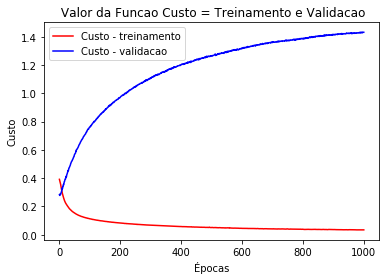

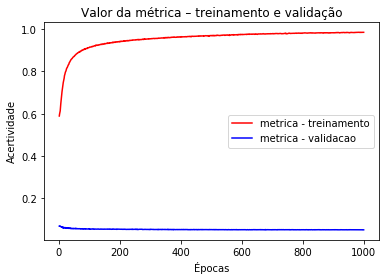

In [21]:
rna0.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna0.plot()

Confusion matrix, without normalization
[[24828  2157]
 [ 1955  1060]]


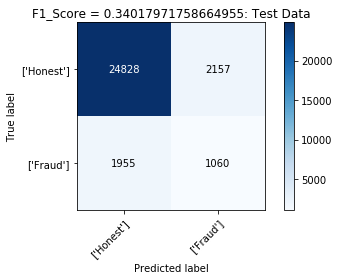

Confusion matrix, without normalization
[[24800  2186]
 [ 1967  1048]]


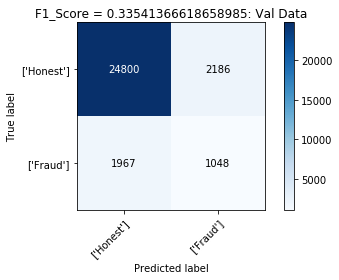

Confusion matrix, without normalization
[[125340    591]
 [   546  41658]]


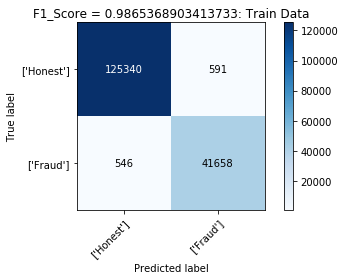

In [22]:
rna0.predict(x_data,y_data)

In [23]:
n_list1 = [100,1]
activation_list1 = ['tanh','sigmoid']

In [24]:
rna1 = new_rna()
rna1.build_model(data_shape,n_list1,activation_list1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 20,201
Trainable params: 20,201
Non-trainable params: 0
_________________________________________________________________


Train on 168135 samples, validate on 30001 samples
Epoch 1/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.3922 - f1: 0.5900 - val_loss: 0.2732 - val_f1: 0.0664
Epoch 2/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.3844 - f1: 0.5963 - val_loss: 0.2878 - val_f1: 0.0707
Epoch 3/1000
168135/168135 [==============================] - 5s 33us/step - loss: 0.3794 - f1: 0.6000 - val_loss: 0.2854 - val_f1: 0.0683
Epoch 4/1000
168135/168135 [==============================] - 5s 33us/step - loss: 0.3713 - f1: 0.6075 - val_loss: 0.2854 - val_f1: 0.0652
Epoch 5/1000
168135/168135 [==============================] - 6s 33us/step - loss: 0.3601 - f1: 0.6198 - val_loss: 0.2973 - val_f1: 0.0688
Epoch 6/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.3457 - f1: 0.6435 - val_loss: 0.2999 - val_f1: 0.0686
Epoch 7/1000
168135/168135 [==============================] - 6s 33us/step - loss: 0.3307 - f1: 0.6623 - val_loss: 

168135/168135 [==============================] - 6s 34us/step - loss: 0.0341 - f1: 0.9742 - val_loss: 1.0949 - val_f1: 0.0500
Epoch 60/1000
168135/168135 [==============================] - 6s 33us/step - loss: 0.0330 - f1: 0.9757 - val_loss: 1.1179 - val_f1: 0.0509
Epoch 61/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0341 - f1: 0.9740 - val_loss: 1.1143 - val_f1: 0.0499
Epoch 62/1000
168135/168135 [==============================] - 6s 33us/step - loss: 0.0331 - f1: 0.9750 - val_loss: 1.1192 - val_f1: 0.0507
Epoch 63/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0324 - f1: 0.9760 - val_loss: 1.1421 - val_f1: 0.0502
Epoch 64/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0281 - f1: 0.9801 - val_loss: 1.1454 - val_f1: 0.0504
Epoch 65/1000
168135/168135 [==============================] - 6s 33us/step - loss: 0.0243 - f1: 0.9830 - val_loss: 1.1571 - val_f1: 0.0503
Epoch 66/1000
168135/168135 [=====

168135/168135 [==============================] - 6s 33us/step - loss: 8.3943e-04 - f1: 0.9998 - val_loss: 1.3431 - val_f1: 0.0501
Epoch 118/1000
168135/168135 [==============================] - 6s 35us/step - loss: 8.2773e-04 - f1: 0.9998 - val_loss: 1.3440 - val_f1: 0.0502
Epoch 119/1000
168135/168135 [==============================] - 6s 33us/step - loss: 8.1583e-04 - f1: 0.9998 - val_loss: 1.3456 - val_f1: 0.0500
Epoch 120/1000
168135/168135 [==============================] - 6s 35us/step - loss: 8.0440e-04 - f1: 0.9998 - val_loss: 1.3466 - val_f1: 0.0500
Epoch 121/1000
168135/168135 [==============================] - 6s 34us/step - loss: 7.9324e-04 - f1: 1.0000 - val_loss: 1.3482 - val_f1: 0.0501
Epoch 122/1000
168135/168135 [==============================] - 6s 34us/step - loss: 7.8246e-04 - f1: 0.9996 - val_loss: 1.3492 - val_f1: 0.0500
Epoch 123/1000
168135/168135 [==============================] - 6s 35us/step - loss: 7.7211e-04 - f1: 1.0000 - val_loss: 1.3505 - val_f1: 0.0501


168135/168135 [==============================] - 6s 34us/step - loss: 4.7459e-04 - f1: 1.0000 - val_loss: 1.3952 - val_f1: 0.0498
Epoch 174/1000
168135/168135 [==============================] - 6s 33us/step - loss: 4.7124e-04 - f1: 0.9998 - val_loss: 1.3959 - val_f1: 0.0497
Epoch 175/1000
168135/168135 [==============================] - 6s 34us/step - loss: 4.6793e-04 - f1: 0.9994 - val_loss: 1.3963 - val_f1: 0.0497
Epoch 176/1000
168135/168135 [==============================] - 6s 34us/step - loss: 4.6471e-04 - f1: 1.0000 - val_loss: 1.3970 - val_f1: 0.0498
Epoch 177/1000
168135/168135 [==============================] - 6s 33us/step - loss: 4.6138e-04 - f1: 1.0000 - val_loss: 1.3977 - val_f1: 0.0498
Epoch 178/1000
168135/168135 [==============================] - 6s 33us/step - loss: 4.5830e-04 - f1: 1.0000 - val_loss: 1.3983 - val_f1: 0.0498
Epoch 179/1000
168135/168135 [==============================] - 6s 35us/step - loss: 4.5519e-04 - f1: 0.9996 - val_loss: 1.3989 - val_f1: 0.0498


168135/168135 [==============================] - 6s 35us/step - loss: 3.4530e-04 - f1: 0.9998 - val_loss: 1.4233 - val_f1: 0.0497
Epoch 230/1000
168135/168135 [==============================] - 6s 33us/step - loss: 3.4382e-04 - f1: 0.9999 - val_loss: 1.4239 - val_f1: 0.0497
Epoch 231/1000
168135/168135 [==============================] - 6s 33us/step - loss: 3.4226e-04 - f1: 1.0000 - val_loss: 1.4243 - val_f1: 0.0498
Epoch 232/1000
168135/168135 [==============================] - 6s 35us/step - loss: 3.4076e-04 - f1: 1.0000 - val_loss: 1.4246 - val_f1: 0.0498
Epoch 233/1000
168135/168135 [==============================] - 6s 33us/step - loss: 3.3927e-04 - f1: 1.0000 - val_loss: 1.4253 - val_f1: 0.0499
Epoch 234/1000
168135/168135 [==============================] - 6s 33us/step - loss: 3.3782e-04 - f1: 0.9996 - val_loss: 1.4256 - val_f1: 0.0499
Epoch 235/1000
168135/168135 [==============================] - 6s 35us/step - loss: 3.3636e-04 - f1: 1.0000 - val_loss: 1.4257 - val_f1: 0.0499


168135/168135 [==============================] - 6s 35us/step - loss: 2.8015e-04 - f1: 0.9998 - val_loss: 1.4426 - val_f1: 0.0500
Epoch 286/1000
168135/168135 [==============================] - 6s 34us/step - loss: 2.7929e-04 - f1: 0.9998 - val_loss: 1.4431 - val_f1: 0.0500
Epoch 287/1000
168135/168135 [==============================] - 6s 35us/step - loss: 2.7842e-04 - f1: 1.0000 - val_loss: 1.4432 - val_f1: 0.0500
Epoch 288/1000
168135/168135 [==============================] - 6s 33us/step - loss: 2.7759e-04 - f1: 1.0000 - val_loss: 1.4435 - val_f1: 0.0500
Epoch 289/1000
168135/168135 [==============================] - 6s 34us/step - loss: 2.7673e-04 - f1: 0.9999 - val_loss: 1.4440 - val_f1: 0.0501
Epoch 290/1000
168135/168135 [==============================] - 6s 36us/step - loss: 2.7591e-04 - f1: 1.0000 - val_loss: 1.4444 - val_f1: 0.0501
Epoch 291/1000
168135/168135 [==============================] - 6s 33us/step - loss: 2.7507e-04 - f1: 1.0000 - val_loss: 1.4444 - val_f1: 0.0501


168135/168135 [==============================] - 6s 33us/step - loss: 2.4122e-04 - f1: 1.0000 - val_loss: 1.4573 - val_f1: 0.0502
Epoch 342/1000
168135/168135 [==============================] - 6s 36us/step - loss: 2.4066e-04 - f1: 1.0000 - val_loss: 1.4572 - val_f1: 0.0502
Epoch 343/1000
168135/168135 [==============================] - 6s 33us/step - loss: 2.4011e-04 - f1: 1.0000 - val_loss: 1.4575 - val_f1: 0.0502
Epoch 344/1000
168135/168135 [==============================] - 6s 33us/step - loss: 2.3956e-04 - f1: 0.9996 - val_loss: 1.4577 - val_f1: 0.0503
Epoch 345/1000
168135/168135 [==============================] - 6s 35us/step - loss: 2.3903e-04 - f1: 1.0000 - val_loss: 1.4579 - val_f1: 0.0502
Epoch 346/1000
168135/168135 [==============================] - 6s 33us/step - loss: 2.3850e-04 - f1: 0.9998 - val_loss: 1.4581 - val_f1: 0.0502
Epoch 347/1000
168135/168135 [==============================] - 6s 33us/step - loss: 2.3795e-04 - f1: 0.9994 - val_loss: 1.4584 - val_f1: 0.0502


168135/168135 [==============================] - 6s 35us/step - loss: 2.1544e-04 - f1: 1.0000 - val_loss: 1.4683 - val_f1: 0.0502
Epoch 398/1000
168135/168135 [==============================] - 6s 33us/step - loss: 2.1507e-04 - f1: 0.9998 - val_loss: 1.4685 - val_f1: 0.0502
Epoch 399/1000
168135/168135 [==============================] - 6s 34us/step - loss: 2.1467e-04 - f1: 1.0000 - val_loss: 1.4688 - val_f1: 0.0502
Epoch 400/1000
168135/168135 [==============================] - 6s 35us/step - loss: 2.1430e-04 - f1: 1.0000 - val_loss: 1.4689 - val_f1: 0.0502
Epoch 401/1000
168135/168135 [==============================] - 6s 33us/step - loss: 2.1393e-04 - f1: 0.9998 - val_loss: 1.4693 - val_f1: 0.0502
Epoch 402/1000
168135/168135 [==============================] - 6s 33us/step - loss: 2.1356e-04 - f1: 0.9998 - val_loss: 1.4693 - val_f1: 0.0502
Epoch 403/1000
168135/168135 [==============================] - 6s 35us/step - loss: 2.1319e-04 - f1: 0.9999 - val_loss: 1.4694 - val_f1: 0.0502


168135/168135 [==============================] - 6s 34us/step - loss: 1.9718e-04 - f1: 1.0000 - val_loss: 1.4777 - val_f1: 0.0502
Epoch 454/1000
168135/168135 [==============================] - 5s 31us/step - loss: 1.9690e-04 - f1: 0.9996 - val_loss: 1.4777 - val_f1: 0.0502
Epoch 455/1000
168135/168135 [==============================] - 6s 33us/step - loss: 1.9661e-04 - f1: 0.9998 - val_loss: 1.4779 - val_f1: 0.0502
Epoch 456/1000
168135/168135 [==============================] - 5s 32us/step - loss: 1.9634e-04 - f1: 0.9998 - val_loss: 1.4779 - val_f1: 0.0502
Epoch 457/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.9607e-04 - f1: 1.0000 - val_loss: 1.4783 - val_f1: 0.0502
Epoch 458/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.9579e-04 - f1: 0.9998 - val_loss: 1.4784 - val_f1: 0.0502
Epoch 459/1000
168135/168135 [==============================] - 6s 35us/step - loss: 1.9553e-04 - f1: 0.9998 - val_loss: 1.4786 - val_f1: 0.0502


168135/168135 [==============================] - 6s 34us/step - loss: 1.8357e-04 - f1: 1.0000 - val_loss: 1.4855 - val_f1: 0.0503
Epoch 510/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.8336e-04 - f1: 0.9998 - val_loss: 1.4855 - val_f1: 0.0502
Epoch 511/1000
168135/168135 [==============================] - 6s 35us/step - loss: 1.8316e-04 - f1: 0.9996 - val_loss: 1.4858 - val_f1: 0.0502
Epoch 512/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.8294e-04 - f1: 0.9999 - val_loss: 1.4857 - val_f1: 0.0503
Epoch 513/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.8273e-04 - f1: 0.9999 - val_loss: 1.4860 - val_f1: 0.0502
Epoch 514/1000
168135/168135 [==============================] - 6s 36us/step - loss: 1.8253e-04 - f1: 1.0000 - val_loss: 1.4860 - val_f1: 0.0503
Epoch 515/1000
168135/168135 [==============================] - 6s 33us/step - loss: 1.8232e-04 - f1: 0.9998 - val_loss: 1.4863 - val_f1: 0.0502


168135/168135 [==============================] - 6s 33us/step - loss: 1.7307e-04 - f1: 1.0000 - val_loss: 1.4922 - val_f1: 0.0503
Epoch 566/1000
168135/168135 [==============================] - 6s 35us/step - loss: 1.7290e-04 - f1: 1.0000 - val_loss: 1.4923 - val_f1: 0.0503
Epoch 567/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.7274e-04 - f1: 1.0000 - val_loss: 1.4924 - val_f1: 0.0503
Epoch 568/1000
168135/168135 [==============================] - 6s 36us/step - loss: 1.7258e-04 - f1: 1.0000 - val_loss: 1.4925 - val_f1: 0.0503
Epoch 569/1000
168135/168135 [==============================] - 6s 33us/step - loss: 1.7241e-04 - f1: 0.9998 - val_loss: 1.4927 - val_f1: 0.0503
Epoch 570/1000
168135/168135 [==============================] - 6s 35us/step - loss: 1.7225e-04 - f1: 1.0000 - val_loss: 1.4928 - val_f1: 0.0503
Epoch 571/1000
168135/168135 [==============================] - 6s 35us/step - loss: 1.7208e-04 - f1: 1.0000 - val_loss: 1.4930 - val_f1: 0.0503


168135/168135 [==============================] - 6s 34us/step - loss: 1.6472e-04 - f1: 1.0000 - val_loss: 1.4981 - val_f1: 0.0502
Epoch 622/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.6459e-04 - f1: 1.0000 - val_loss: 1.4981 - val_f1: 0.0503
Epoch 623/1000
168135/168135 [==============================] - 6s 35us/step - loss: 1.6446e-04 - f1: 1.0000 - val_loss: 1.4981 - val_f1: 0.0502
Epoch 624/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.6433e-04 - f1: 0.9998 - val_loss: 1.4982 - val_f1: 0.0502
Epoch 625/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.6419e-04 - f1: 1.0000 - val_loss: 1.4985 - val_f1: 0.0502
Epoch 626/1000
168135/168135 [==============================] - 6s 35us/step - loss: 1.6406e-04 - f1: 0.9998 - val_loss: 1.4986 - val_f1: 0.0502
Epoch 627/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.6393e-04 - f1: 1.0000 - val_loss: 1.4986 - val_f1: 0.0502


168135/168135 [==============================] - 6s 34us/step - loss: 1.5793e-04 - f1: 1.0000 - val_loss: 1.5033 - val_f1: 0.0502
Epoch 678/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.5783e-04 - f1: 1.0000 - val_loss: 1.5033 - val_f1: 0.0502
Epoch 679/1000
168135/168135 [==============================] - 6s 35us/step - loss: 1.5772e-04 - f1: 1.0000 - val_loss: 1.5035 - val_f1: 0.0502
Epoch 680/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.5761e-04 - f1: 0.9998 - val_loss: 1.5033 - val_f1: 0.0502
Epoch 681/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.5750e-04 - f1: 1.0000 - val_loss: 1.5036 - val_f1: 0.0502
Epoch 682/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.5739e-04 - f1: 0.9999 - val_loss: 1.5034 - val_f1: 0.0502
Epoch 683/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.5728e-04 - f1: 0.9999 - val_loss: 1.5038 - val_f1: 0.0502


168135/168135 [==============================] - 6s 34us/step - loss: 1.5231e-04 - f1: 1.0000 - val_loss: 1.5078 - val_f1: 0.0502
Epoch 734/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.5222e-04 - f1: 0.9996 - val_loss: 1.5079 - val_f1: 0.0502
Epoch 735/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.5213e-04 - f1: 1.0000 - val_loss: 1.5079 - val_f1: 0.0502
Epoch 736/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.5203e-04 - f1: 1.0000 - val_loss: 1.5081 - val_f1: 0.0502
Epoch 737/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.5194e-04 - f1: 1.0000 - val_loss: 1.5081 - val_f1: 0.0502
Epoch 738/1000
168135/168135 [==============================] - 6s 33us/step - loss: 1.5185e-04 - f1: 1.0000 - val_loss: 1.5082 - val_f1: 0.0502
Epoch 739/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.5176e-04 - f1: 1.0000 - val_loss: 1.5084 - val_f1: 0.0502


168135/168135 [==============================] - 5s 31us/step - loss: 1.4757e-04 - f1: 1.0000 - val_loss: 1.5121 - val_f1: 0.0502
Epoch 790/1000
168135/168135 [==============================] - 6s 33us/step - loss: 1.4750e-04 - f1: 1.0000 - val_loss: 1.5121 - val_f1: 0.0502
Epoch 791/1000
168135/168135 [==============================] - 5s 32us/step - loss: 1.4742e-04 - f1: 0.9998 - val_loss: 1.5120 - val_f1: 0.0502
Epoch 792/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.4734e-04 - f1: 0.9998 - val_loss: 1.5123 - val_f1: 0.0502
Epoch 793/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.4726e-04 - f1: 1.0000 - val_loss: 1.5123 - val_f1: 0.0502
Epoch 794/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.4719e-04 - f1: 0.9998 - val_loss: 1.5123 - val_f1: 0.0502
Epoch 795/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.4711e-04 - f1: 0.9998 - val_loss: 1.5124 - val_f1: 0.0502


168135/168135 [==============================] - 6s 34us/step - loss: 1.4353e-04 - f1: 1.0000 - val_loss: 1.5160 - val_f1: 0.0503
Epoch 846/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.4347e-04 - f1: 0.9999 - val_loss: 1.5160 - val_f1: 0.0503
Epoch 847/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.4340e-04 - f1: 1.0000 - val_loss: 1.5160 - val_f1: 0.0503
Epoch 848/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.4333e-04 - f1: 1.0000 - val_loss: 1.5161 - val_f1: 0.0503
Epoch 849/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.4327e-04 - f1: 1.0000 - val_loss: 1.5163 - val_f1: 0.0503
Epoch 850/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.4320e-04 - f1: 0.9996 - val_loss: 1.5162 - val_f1: 0.0503
Epoch 851/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.4314e-04 - f1: 0.9998 - val_loss: 1.5162 - val_f1: 0.0503


168135/168135 [==============================] - 6s 34us/step - loss: 1.4005e-04 - f1: 0.9999 - val_loss: 1.5194 - val_f1: 0.0503
Epoch 902/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.3999e-04 - f1: 0.9998 - val_loss: 1.5194 - val_f1: 0.0503
Epoch 903/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.3994e-04 - f1: 1.0000 - val_loss: 1.5196 - val_f1: 0.0503
Epoch 904/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.3988e-04 - f1: 0.9998 - val_loss: 1.5196 - val_f1: 0.0503
Epoch 905/1000
168135/168135 [==============================] - 6s 33us/step - loss: 1.3982e-04 - f1: 1.0000 - val_loss: 1.5197 - val_f1: 0.0503
Epoch 906/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.3976e-04 - f1: 0.9996 - val_loss: 1.5197 - val_f1: 0.0503
Epoch 907/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.3971e-04 - f1: 0.9998 - val_loss: 1.5198 - val_f1: 0.0503


168135/168135 [==============================] - 6s 34us/step - loss: 1.3702e-04 - f1: 1.0000 - val_loss: 1.5226 - val_f1: 0.0502
Epoch 958/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.3697e-04 - f1: 0.9996 - val_loss: 1.5226 - val_f1: 0.0502
Epoch 959/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.3692e-04 - f1: 1.0000 - val_loss: 1.5227 - val_f1: 0.0502
Epoch 960/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.3687e-04 - f1: 1.0000 - val_loss: 1.5228 - val_f1: 0.0502
Epoch 961/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.3682e-04 - f1: 1.0000 - val_loss: 1.5228 - val_f1: 0.0502
Epoch 962/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.3677e-04 - f1: 1.0000 - val_loss: 1.5228 - val_f1: 0.0502
Epoch 963/1000
168135/168135 [==============================] - 6s 34us/step - loss: 1.3672e-04 - f1: 0.9998 - val_loss: 1.5229 - val_f1: 0.0502


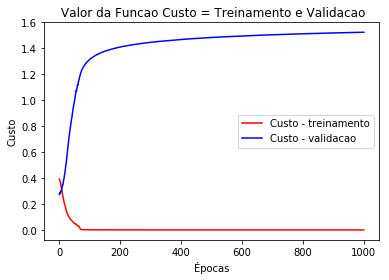

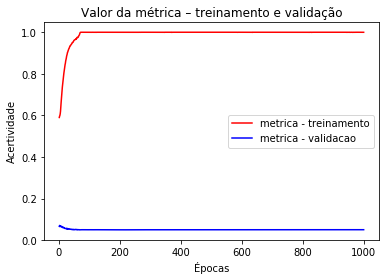

In [25]:
rna1.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna1.plot()

Confusion matrix, without normalization
[[24977  2008]
 [ 1986  1029]]


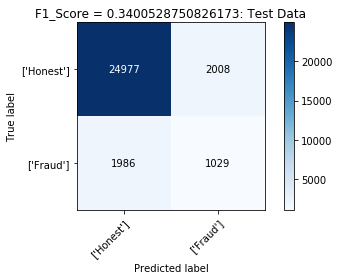

Confusion matrix, without normalization
[[25031  1955]
 [ 1999  1016]]


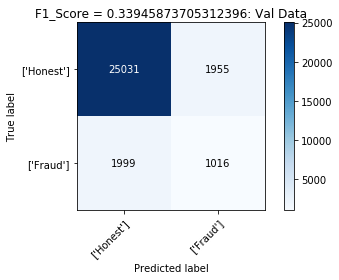

Confusion matrix, without normalization
[[125930      1]
 [     0  42204]]


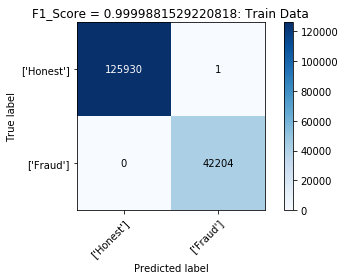

In [26]:
rna1.predict(x_data,y_data)

In [27]:
n_list2 = [50,50,1]
activation_list2 = ['tanh','tanh','sigmoid']

In [28]:
rna2 = new_rna()
rna2.build_model(data_shape,n_list2,activation_list2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 12,651
Trainable params: 12,651
Non-trainable params: 0
_________________________________________________________________


Train on 168135 samples, validate on 30001 samples
Epoch 1/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.3906 - f1: 0.5890 - val_loss: 0.2857 - val_f1: 0.0690
Epoch 2/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.3736 - f1: 0.6043 - val_loss: 0.2767 - val_f1: 0.0644
Epoch 3/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.3555 - f1: 0.6283 - val_loss: 0.2820 - val_f1: 0.0607
Epoch 4/1000
168135/168135 [==============================] - 6s 33us/step - loss: 0.3351 - f1: 0.6551 - val_loss: 0.3131 - val_f1: 0.0686
Epoch 5/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.3137 - f1: 0.6859 - val_loss: 0.3087 - val_f1: 0.0625
Epoch 6/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.2945 - f1: 0.7118 - val_loss: 0.3179 - val_f1: 0.0633
Epoch 7/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.2773 - f1: 0.7334 - val_loss: 

168135/168135 [==============================] - 6s 34us/step - loss: 0.1184 - f1: 0.9014 - val_loss: 0.6094 - val_f1: 0.0533
Epoch 60/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.1207 - f1: 0.8994 - val_loss: 0.6174 - val_f1: 0.0546
Epoch 61/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.1173 - f1: 0.9039 - val_loss: 0.6197 - val_f1: 0.0535
Epoch 62/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.1193 - f1: 0.9007 - val_loss: 0.6230 - val_f1: 0.0547
Epoch 63/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.1145 - f1: 0.9055 - val_loss: 0.6351 - val_f1: 0.0526
Epoch 64/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.1166 - f1: 0.9027 - val_loss: 0.6297 - val_f1: 0.0521
Epoch 65/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.1157 - f1: 0.9047 - val_loss: 0.6419 - val_f1: 0.0557
Epoch 66/1000
168135/168135 [=====

168135/168135 [==============================] - 6s 34us/step - loss: 0.0934 - f1: 0.9254 - val_loss: 0.7365 - val_f1: 0.0523
Epoch 118/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.0949 - f1: 0.9237 - val_loss: 0.7386 - val_f1: 0.0529
Epoch 119/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0943 - f1: 0.9248 - val_loss: 0.7430 - val_f1: 0.0524
Epoch 120/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0973 - f1: 0.9211 - val_loss: 0.7402 - val_f1: 0.0527
Epoch 121/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0939 - f1: 0.9250 - val_loss: 0.7391 - val_f1: 0.0535
Epoch 122/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0903 - f1: 0.9265 - val_loss: 0.7475 - val_f1: 0.0545
Epoch 123/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.0903 - f1: 0.9268 - val_loss: 0.7519 - val_f1: 0.0520
Epoch 124/1000
168135/168135

168135/168135 [==============================] - 6s 35us/step - loss: 0.0818 - f1: 0.9354 - val_loss: 0.8049 - val_f1: 0.0536
Epoch 176/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0837 - f1: 0.9343 - val_loss: 0.8011 - val_f1: 0.0516
Epoch 177/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0843 - f1: 0.9324 - val_loss: 0.8049 - val_f1: 0.0519
Epoch 178/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0852 - f1: 0.9320 - val_loss: 0.8000 - val_f1: 0.0522
Epoch 179/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0813 - f1: 0.9345 - val_loss: 0.8062 - val_f1: 0.0510
Epoch 180/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.0827 - f1: 0.9323 - val_loss: 0.7991 - val_f1: 0.0509
Epoch 181/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0838 - f1: 0.9338 - val_loss: 0.7969 - val_f1: 0.0505
Epoch 182/1000
168135/168135

168135/168135 [==============================] - 6s 35us/step - loss: 0.0720 - f1: 0.9436 - val_loss: 0.8449 - val_f1: 0.0515
Epoch 234/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.0757 - f1: 0.9412 - val_loss: 0.8441 - val_f1: 0.0519
Epoch 235/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0743 - f1: 0.9413 - val_loss: 0.8472 - val_f1: 0.0521
Epoch 236/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0763 - f1: 0.9405 - val_loss: 0.8473 - val_f1: 0.0522
Epoch 237/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0720 - f1: 0.9439 - val_loss: 0.8459 - val_f1: 0.0506
Epoch 238/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0752 - f1: 0.9410 - val_loss: 0.8475 - val_f1: 0.0505
Epoch 239/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0756 - f1: 0.9410 - val_loss: 0.8476 - val_f1: 0.0523
Epoch 240/1000
168135/168135

168135/168135 [==============================] - 6s 34us/step - loss: 0.0696 - f1: 0.9458 - val_loss: 0.8797 - val_f1: 0.0507
Epoch 292/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.0655 - f1: 0.9502 - val_loss: 0.8762 - val_f1: 0.0509
Epoch 293/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0635 - f1: 0.9506 - val_loss: 0.8861 - val_f1: 0.0516
Epoch 294/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0658 - f1: 0.9499 - val_loss: 0.8982 - val_f1: 0.0517
Epoch 295/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.0721 - f1: 0.9453 - val_loss: 0.8964 - val_f1: 0.0508
Epoch 296/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0736 - f1: 0.9429 - val_loss: 0.8870 - val_f1: 0.0511
Epoch 297/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0709 - f1: 0.9449 - val_loss: 0.8785 - val_f1: 0.0511
Epoch 298/1000
168135/168135

168135/168135 [==============================] - 6s 35us/step - loss: 0.0665 - f1: 0.9499 - val_loss: 0.9129 - val_f1: 0.0492
Epoch 350/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0669 - f1: 0.9481 - val_loss: 0.9134 - val_f1: 0.0521
Epoch 351/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0631 - f1: 0.9520 - val_loss: 0.9219 - val_f1: 0.0505
Epoch 352/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.0630 - f1: 0.9520 - val_loss: 0.9267 - val_f1: 0.0507
Epoch 353/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0612 - f1: 0.9532 - val_loss: 0.9202 - val_f1: 0.0509
Epoch 354/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.0651 - f1: 0.9511 - val_loss: 0.9218 - val_f1: 0.0516
Epoch 355/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0663 - f1: 0.9494 - val_loss: 0.9116 - val_f1: 0.0505
Epoch 356/1000
168135/168135

168135/168135 [==============================] - 6s 34us/step - loss: 0.0646 - f1: 0.9505 - val_loss: 0.9275 - val_f1: 0.0502
Epoch 408/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.0635 - f1: 0.9529 - val_loss: 0.9352 - val_f1: 0.0505
Epoch 409/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0682 - f1: 0.9469 - val_loss: 0.9191 - val_f1: 0.0505
Epoch 410/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0619 - f1: 0.9521 - val_loss: 0.9218 - val_f1: 0.0506
Epoch 411/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.0610 - f1: 0.9539 - val_loss: 0.9235 - val_f1: 0.0514
Epoch 412/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0610 - f1: 0.9525 - val_loss: 0.9260 - val_f1: 0.0504
Epoch 413/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0605 - f1: 0.9527 - val_loss: 0.9276 - val_f1: 0.0505
Epoch 414/1000
168135/168135

168135/168135 [==============================] - 6s 36us/step - loss: 0.0630 - f1: 0.9519 - val_loss: 0.9581 - val_f1: 0.0514
Epoch 466/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0646 - f1: 0.9510 - val_loss: 0.9467 - val_f1: 0.0509
Epoch 467/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0616 - f1: 0.9537 - val_loss: 0.9618 - val_f1: 0.0514
Epoch 468/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.0584 - f1: 0.9560 - val_loss: 0.9588 - val_f1: 0.0508
Epoch 469/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0568 - f1: 0.9572 - val_loss: 0.9583 - val_f1: 0.0513
Epoch 470/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0564 - f1: 0.9563 - val_loss: 0.9710 - val_f1: 0.0511
Epoch 471/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0603 - f1: 0.9546 - val_loss: 0.9742 - val_f1: 0.0489
Epoch 472/1000
168135/168135

168135/168135 [==============================] - 6s 34us/step - loss: 0.0653 - f1: 0.9513 - val_loss: 0.9877 - val_f1: 0.0515
Epoch 524/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.0622 - f1: 0.9537 - val_loss: 0.9713 - val_f1: 0.0516
Epoch 525/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0584 - f1: 0.9555 - val_loss: 0.9798 - val_f1: 0.0509
Epoch 526/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0573 - f1: 0.9567 - val_loss: 0.9702 - val_f1: 0.0514
Epoch 527/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.0551 - f1: 0.9590 - val_loss: 0.9739 - val_f1: 0.0510
Epoch 528/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0549 - f1: 0.9597 - val_loss: 0.9834 - val_f1: 0.0500
Epoch 529/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0576 - f1: 0.9582 - val_loss: 0.9847 - val_f1: 0.0507
Epoch 530/1000
168135/168135

168135/168135 [==============================] - 6s 36us/step - loss: 0.0535 - f1: 0.9595 - val_loss: 0.9940 - val_f1: 0.0502
Epoch 582/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0553 - f1: 0.9586 - val_loss: 0.9941 - val_f1: 0.0506
Epoch 583/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0579 - f1: 0.9576 - val_loss: 0.9939 - val_f1: 0.0511
Epoch 584/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0558 - f1: 0.9575 - val_loss: 1.0025 - val_f1: 0.0507
Epoch 585/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0536 - f1: 0.9611 - val_loss: 1.0066 - val_f1: 0.0507
Epoch 586/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.0528 - f1: 0.9610 - val_loss: 1.0070 - val_f1: 0.0501
Epoch 587/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0518 - f1: 0.9617 - val_loss: 1.0080 - val_f1: 0.0506
Epoch 588/1000
168135/168135

168135/168135 [==============================] - 6s 35us/step - loss: 0.0583 - f1: 0.9563 - val_loss: 0.9896 - val_f1: 0.0513
Epoch 640/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.0558 - f1: 0.9585 - val_loss: 0.9923 - val_f1: 0.0516
Epoch 641/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0553 - f1: 0.9585 - val_loss: 0.9949 - val_f1: 0.0520
Epoch 642/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0560 - f1: 0.9587 - val_loss: 0.9915 - val_f1: 0.0516
Epoch 643/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0567 - f1: 0.9565 - val_loss: 0.9905 - val_f1: 0.0502
Epoch 644/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0527 - f1: 0.9611 - val_loss: 1.0052 - val_f1: 0.0509
Epoch 645/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.0494 - f1: 0.9631 - val_loss: 1.0212 - val_f1: 0.0511
Epoch 646/1000
168135/168135

168135/168135 [==============================] - 6s 34us/step - loss: 0.0524 - f1: 0.9618 - val_loss: 1.0199 - val_f1: 0.0506
Epoch 698/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0562 - f1: 0.9582 - val_loss: 1.0164 - val_f1: 0.0508
Epoch 699/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.0535 - f1: 0.9604 - val_loss: 1.0148 - val_f1: 0.0509
Epoch 700/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0542 - f1: 0.9599 - val_loss: 1.0177 - val_f1: 0.0507
Epoch 701/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0510 - f1: 0.9626 - val_loss: 1.0216 - val_f1: 0.0504
Epoch 702/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0507 - f1: 0.9624 - val_loss: 1.0236 - val_f1: 0.0502
Epoch 703/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0478 - f1: 0.9653 - val_loss: 1.0260 - val_f1: 0.0510
Epoch 704/1000
168135/168135

168135/168135 [==============================] - 6s 36us/step - loss: 0.0541 - f1: 0.9608 - val_loss: 1.0343 - val_f1: 0.0507
Epoch 756/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.0528 - f1: 0.9621 - val_loss: 1.0291 - val_f1: 0.0504
Epoch 757/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0505 - f1: 0.9637 - val_loss: 1.0329 - val_f1: 0.0513
Epoch 758/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.0512 - f1: 0.9626 - val_loss: 1.0357 - val_f1: 0.0506
Epoch 759/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0508 - f1: 0.9633 - val_loss: 1.0348 - val_f1: 0.0504
Epoch 760/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.0509 - f1: 0.9622 - val_loss: 1.0374 - val_f1: 0.0508
Epoch 761/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0514 - f1: 0.9621 - val_loss: 1.0458 - val_f1: 0.0501
Epoch 762/1000
168135/168135

168135/168135 [==============================] - 6s 34us/step - loss: 0.0508 - f1: 0.9622 - val_loss: 1.0400 - val_f1: 0.0509
Epoch 814/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.0492 - f1: 0.9649 - val_loss: 1.0381 - val_f1: 0.0509
Epoch 815/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0498 - f1: 0.9635 - val_loss: 1.0419 - val_f1: 0.0505
Epoch 816/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.0530 - f1: 0.9628 - val_loss: 1.0445 - val_f1: 0.0512
Epoch 817/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0523 - f1: 0.9616 - val_loss: 1.0403 - val_f1: 0.0508
Epoch 818/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0518 - f1: 0.9625 - val_loss: 1.0418 - val_f1: 0.0513
Epoch 819/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0467 - f1: 0.9668 - val_loss: 1.0385 - val_f1: 0.0505
Epoch 820/1000
168135/168135

168135/168135 [==============================] - 6s 35us/step - loss: 0.0494 - f1: 0.9645 - val_loss: 1.0449 - val_f1: 0.0504
Epoch 872/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.0491 - f1: 0.9646 - val_loss: 1.0432 - val_f1: 0.0496
Epoch 873/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0538 - f1: 0.9603 - val_loss: 1.0475 - val_f1: 0.0494
Epoch 874/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0542 - f1: 0.9612 - val_loss: 1.0458 - val_f1: 0.0507
Epoch 875/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0540 - f1: 0.9608 - val_loss: 1.0382 - val_f1: 0.0511
Epoch 876/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0488 - f1: 0.9638 - val_loss: 1.0434 - val_f1: 0.0509
Epoch 877/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0465 - f1: 0.9672 - val_loss: 1.0469 - val_f1: 0.0505
Epoch 878/1000
168135/168135

168135/168135 [==============================] - 6s 36us/step - loss: 0.0582 - f1: 0.9576 - val_loss: 1.0472 - val_f1: 0.0501
Epoch 930/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0517 - f1: 0.9611 - val_loss: 1.0602 - val_f1: 0.0494
Epoch 931/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.0510 - f1: 0.9624 - val_loss: 1.0503 - val_f1: 0.0498
Epoch 932/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0501 - f1: 0.9633 - val_loss: 1.0469 - val_f1: 0.0498
Epoch 933/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0476 - f1: 0.9657 - val_loss: 1.0528 - val_f1: 0.0492
Epoch 934/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.0460 - f1: 0.9664 - val_loss: 1.0563 - val_f1: 0.0499
Epoch 935/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0445 - f1: 0.9683 - val_loss: 1.0600 - val_f1: 0.0495
Epoch 936/1000
168135/168135

168135/168135 [==============================] - 6s 34us/step - loss: 0.0429 - f1: 0.9703 - val_loss: 1.0773 - val_f1: 0.0501
Epoch 988/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.0444 - f1: 0.9689 - val_loss: 1.0860 - val_f1: 0.0498
Epoch 989/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0482 - f1: 0.9653 - val_loss: 1.0845 - val_f1: 0.0494
Epoch 990/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.0465 - f1: 0.9661 - val_loss: 1.0735 - val_f1: 0.0504
Epoch 991/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0474 - f1: 0.9668 - val_loss: 1.0866 - val_f1: 0.0512
Epoch 992/1000
168135/168135 [==============================] - 6s 34us/step - loss: 0.0493 - f1: 0.9650 - val_loss: 1.0828 - val_f1: 0.0508
Epoch 993/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0524 - f1: 0.9632 - val_loss: 1.0731 - val_f1: 0.0508
Epoch 994/1000
168135/168135

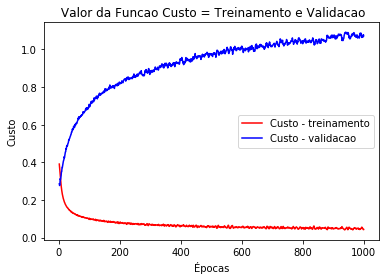

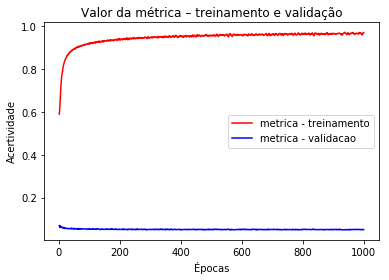

In [29]:
rna2.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna2.plot()

Confusion matrix, without normalization
[[24837  2148]
 [ 1993  1022]]


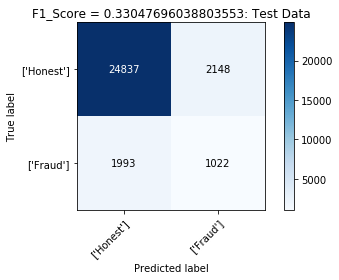

Confusion matrix, without normalization
[[24897  2089]
 [ 1990  1025]]


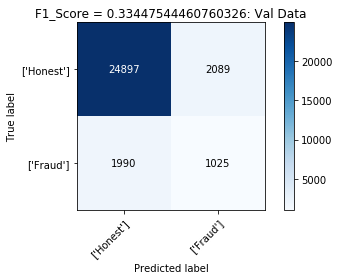

Confusion matrix, without normalization
[[124804   1127]
 [   825  41379]]


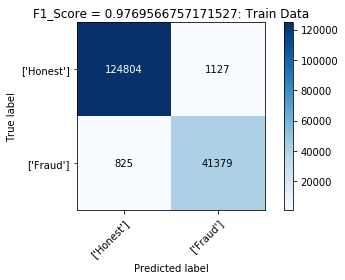

In [30]:
rna2.predict(x_data,y_data)

In [31]:
n_list3 = [100,100,1]
activation_list3 = ['tanh', 'tanh', 'sigmoid']

In [32]:
rna3 = new_rna()
rna3.build_model(data_shape,n_list3,activation_list3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 30,301
Trainable params: 30,301
Non-trainable params: 0
_________________________________________________________________


Train on 168135 samples, validate on 30001 samples
Epoch 1/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.3917 - f1: 0.5876 - val_loss: 0.2880 - val_f1: 0.0711
Epoch 2/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.3774 - f1: 0.5970 - val_loss: 0.2773 - val_f1: 0.0609
Epoch 3/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.3583 - f1: 0.6206 - val_loss: 0.2898 - val_f1: 0.0670
Epoch 4/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.3307 - f1: 0.6611 - val_loss: 0.2984 - val_f1: 0.0644
Epoch 5/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2963 - f1: 0.7108 - val_loss: 0.3301 - val_f1: 0.0652
Epoch 6/1000
168135/168135 [==============================] - 7s 39us/step - loss: 0.2581 - f1: 0.7573 - val_loss: 0.3542 - val_f1: 0.0631
Epoch 7/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2241 - f1: 0.7973 - val_loss: 

Epoch 59/1000
168135/168135 [==============================] - 6s 37us/step - loss: 2.8131e-04 - f1: 1.0000 - val_loss: 1.0040 - val_f1: 0.0493
Epoch 60/1000
168135/168135 [==============================] - 6s 37us/step - loss: 2.7169e-04 - f1: 1.0000 - val_loss: 1.0058 - val_f1: 0.0494
Epoch 61/1000
168135/168135 [==============================] - 7s 39us/step - loss: 2.6279e-04 - f1: 1.0000 - val_loss: 1.0073 - val_f1: 0.0492
Epoch 62/1000
168135/168135 [==============================] - 6s 37us/step - loss: 2.5448e-04 - f1: 0.9998 - val_loss: 1.0091 - val_f1: 0.0493
Epoch 63/1000
168135/168135 [==============================] - 7s 39us/step - loss: 2.4670e-04 - f1: 0.9998 - val_loss: 1.0106 - val_f1: 0.0493
Epoch 64/1000
168135/168135 [==============================] - 6s 38us/step - loss: 2.3948e-04 - f1: 1.0000 - val_loss: 1.0123 - val_f1: 0.0492
Epoch 65/1000
168135/168135 [==============================] - 6s 37us/step - loss: 2.3263e-04 - f1: 0.9998 - val_loss: 1.0139 - val_f1:

Epoch 116/1000
168135/168135 [==============================] - 6s 37us/step - loss: 9.7496e-05 - f1: 1.0000 - val_loss: 1.0610 - val_f1: 0.0491
Epoch 117/1000
168135/168135 [==============================] - 7s 39us/step - loss: 9.6419e-05 - f1: 0.9996 - val_loss: 1.0616 - val_f1: 0.0490
Epoch 118/1000
168135/168135 [==============================] - 6s 38us/step - loss: 9.5367e-05 - f1: 0.9998 - val_loss: 1.0622 - val_f1: 0.0490
Epoch 119/1000
168135/168135 [==============================] - 6s 37us/step - loss: 9.4340e-05 - f1: 1.0000 - val_loss: 1.0630 - val_f1: 0.0491
Epoch 120/1000
168135/168135 [==============================] - 7s 39us/step - loss: 9.3332e-05 - f1: 0.9998 - val_loss: 1.0635 - val_f1: 0.0491
Epoch 121/1000
168135/168135 [==============================] - 6s 38us/step - loss: 9.2350e-05 - f1: 0.9998 - val_loss: 1.0641 - val_f1: 0.0491
Epoch 122/1000
168135/168135 [==============================] - 7s 40us/step - loss: 9.1385e-05 - f1: 1.0000 - val_loss: 1.0647 - 

168135/168135 [==============================] - 7s 39us/step - loss: 6.0174e-05 - f1: 1.0000 - val_loss: 1.0872 - val_f1: 0.0489
Epoch 173/1000
168135/168135 [==============================] - 6s 37us/step - loss: 5.9769e-05 - f1: 0.9998 - val_loss: 1.0876 - val_f1: 0.0490
Epoch 174/1000
168135/168135 [==============================] - 7s 39us/step - loss: 5.9367e-05 - f1: 0.9998 - val_loss: 1.0880 - val_f1: 0.0489
Epoch 175/1000
168135/168135 [==============================] - 6s 38us/step - loss: 5.8971e-05 - f1: 0.9998 - val_loss: 1.0883 - val_f1: 0.0489
Epoch 176/1000
168135/168135 [==============================] - 6s 37us/step - loss: 5.8581e-05 - f1: 0.9996 - val_loss: 1.0886 - val_f1: 0.0489
Epoch 177/1000
168135/168135 [==============================] - 7s 39us/step - loss: 5.8194e-05 - f1: 1.0000 - val_loss: 1.0891 - val_f1: 0.0489
Epoch 178/1000
168135/168135 [==============================] - 6s 38us/step - loss: 5.7813e-05 - f1: 1.0000 - val_loss: 1.0895 - val_f1: 0.0489


168135/168135 [==============================] - 7s 39us/step - loss: 4.3594e-05 - f1: 1.0000 - val_loss: 1.1044 - val_f1: 0.0489
Epoch 229/1000
168135/168135 [==============================] - 6s 37us/step - loss: 4.3382e-05 - f1: 1.0000 - val_loss: 1.1048 - val_f1: 0.0489
Epoch 230/1000
168135/168135 [==============================] - 6s 37us/step - loss: 4.3171e-05 - f1: 0.9998 - val_loss: 1.1050 - val_f1: 0.0489
Epoch 231/1000
168135/168135 [==============================] - 7s 39us/step - loss: 4.2962e-05 - f1: 1.0000 - val_loss: 1.1053 - val_f1: 0.0489
Epoch 232/1000
168135/168135 [==============================] - 6s 37us/step - loss: 4.2754e-05 - f1: 0.9998 - val_loss: 1.1056 - val_f1: 0.0489
Epoch 233/1000
168135/168135 [==============================] - 6s 37us/step - loss: 4.2549e-05 - f1: 1.0000 - val_loss: 1.1058 - val_f1: 0.0489
Epoch 234/1000
168135/168135 [==============================] - 7s 39us/step - loss: 4.2346e-05 - f1: 0.9998 - val_loss: 1.1061 - val_f1: 0.0489


168135/168135 [==============================] - 6s 38us/step - loss: 3.4195e-05 - f1: 1.0000 - val_loss: 1.1173 - val_f1: 0.0488
Epoch 285/1000
168135/168135 [==============================] - 7s 39us/step - loss: 3.4064e-05 - f1: 1.0000 - val_loss: 1.1174 - val_f1: 0.0488
Epoch 286/1000
168135/168135 [==============================] - 6s 38us/step - loss: 3.3934e-05 - f1: 0.9996 - val_loss: 1.1176 - val_f1: 0.0488
Epoch 287/1000
168135/168135 [==============================] - 7s 39us/step - loss: 3.3804e-05 - f1: 0.9998 - val_loss: 1.1177 - val_f1: 0.0488
Epoch 288/1000
168135/168135 [==============================] - 6s 37us/step - loss: 3.3676e-05 - f1: 1.0000 - val_loss: 1.1180 - val_f1: 0.0488
Epoch 289/1000
168135/168135 [==============================] - 6s 38us/step - loss: 3.3549e-05 - f1: 1.0000 - val_loss: 1.1183 - val_f1: 0.0488
Epoch 290/1000
168135/168135 [==============================] - 7s 39us/step - loss: 3.3423e-05 - f1: 1.0000 - val_loss: 1.1183 - val_f1: 0.0488


168135/168135 [==============================] - 6s 38us/step - loss: 2.8138e-05 - f1: 0.9994 - val_loss: 1.1273 - val_f1: 0.0488
Epoch 341/1000
168135/168135 [==============================] - 7s 39us/step - loss: 2.8049e-05 - f1: 1.0000 - val_loss: 1.1276 - val_f1: 0.0488
Epoch 342/1000
168135/168135 [==============================] - 6s 38us/step - loss: 2.7962e-05 - f1: 0.9998 - val_loss: 1.1277 - val_f1: 0.0488
Epoch 343/1000
168135/168135 [==============================] - 7s 39us/step - loss: 2.7874e-05 - f1: 0.9998 - val_loss: 1.1278 - val_f1: 0.0488
Epoch 344/1000
168135/168135 [==============================] - 6s 37us/step - loss: 2.7787e-05 - f1: 1.0000 - val_loss: 1.1280 - val_f1: 0.0488
Epoch 345/1000
168135/168135 [==============================] - 6s 38us/step - loss: 2.7701e-05 - f1: 1.0000 - val_loss: 1.1282 - val_f1: 0.0488
Epoch 346/1000
168135/168135 [==============================] - 7s 39us/step - loss: 2.7615e-05 - f1: 1.0000 - val_loss: 1.1284 - val_f1: 0.0488


168135/168135 [==============================] - 6s 38us/step - loss: 2.3914e-05 - f1: 0.9996 - val_loss: 1.1354 - val_f1: 0.0489
Epoch 397/1000
168135/168135 [==============================] - 7s 39us/step - loss: 2.3850e-05 - f1: 0.9998 - val_loss: 1.1356 - val_f1: 0.0489
Epoch 398/1000
168135/168135 [==============================] - 6s 38us/step - loss: 2.3786e-05 - f1: 1.0000 - val_loss: 1.1358 - val_f1: 0.0489
Epoch 399/1000
168135/168135 [==============================] - 6s 38us/step - loss: 2.3723e-05 - f1: 0.9994 - val_loss: 1.1360 - val_f1: 0.0489
Epoch 400/1000
168135/168135 [==============================] - 7s 39us/step - loss: 2.3661e-05 - f1: 0.9996 - val_loss: 1.1361 - val_f1: 0.0489
Epoch 401/1000
168135/168135 [==============================] - 6s 38us/step - loss: 2.3598e-05 - f1: 1.0000 - val_loss: 1.1362 - val_f1: 0.0489
Epoch 402/1000
168135/168135 [==============================] - 7s 40us/step - loss: 2.3536e-05 - f1: 1.0000 - val_loss: 1.1364 - val_f1: 0.0489


168135/168135 [==============================] - 6s 37us/step - loss: 2.0803e-05 - f1: 1.0000 - val_loss: 1.1425 - val_f1: 0.0489
Epoch 453/1000
168135/168135 [==============================] - 6s 38us/step - loss: 2.0755e-05 - f1: 0.9996 - val_loss: 1.1429 - val_f1: 0.0489
Epoch 454/1000
168135/168135 [==============================] - 7s 40us/step - loss: 2.0707e-05 - f1: 1.0000 - val_loss: 1.1428 - val_f1: 0.0489
Epoch 455/1000
168135/168135 [==============================] - 6s 38us/step - loss: 2.0659e-05 - f1: 1.0000 - val_loss: 1.1430 - val_f1: 0.0489
Epoch 456/1000
168135/168135 [==============================] - 7s 40us/step - loss: 2.0612e-05 - f1: 1.0000 - val_loss: 1.1430 - val_f1: 0.0489
Epoch 457/1000
168135/168135 [==============================] - 6s 38us/step - loss: 2.0565e-05 - f1: 1.0000 - val_loss: 1.1431 - val_f1: 0.0489
Epoch 458/1000
168135/168135 [==============================] - 7s 39us/step - loss: 2.0518e-05 - f1: 0.9996 - val_loss: 1.1434 - val_f1: 0.0489


168135/168135 [==============================] - 6s 38us/step - loss: 1.8419e-05 - f1: 1.0000 - val_loss: 1.1487 - val_f1: 0.0489
Epoch 509/1000
168135/168135 [==============================] - 7s 39us/step - loss: 1.8381e-05 - f1: 1.0000 - val_loss: 1.1487 - val_f1: 0.0490
Epoch 510/1000
168135/168135 [==============================] - 6s 38us/step - loss: 1.8344e-05 - f1: 1.0000 - val_loss: 1.1487 - val_f1: 0.0490
Epoch 511/1000
168135/168135 [==============================] - 6s 38us/step - loss: 1.8307e-05 - f1: 0.9996 - val_loss: 1.1489 - val_f1: 0.0490
Epoch 512/1000
168135/168135 [==============================] - 7s 41us/step - loss: 1.8270e-05 - f1: 1.0000 - val_loss: 1.1491 - val_f1: 0.0490
Epoch 513/1000
168135/168135 [==============================] - 6s 39us/step - loss: 1.8233e-05 - f1: 1.0000 - val_loss: 1.1491 - val_f1: 0.0489
Epoch 514/1000
168135/168135 [==============================] - 7s 40us/step - loss: 1.8196e-05 - f1: 1.0000 - val_loss: 1.1491 - val_f1: 0.0489


168135/168135 [==============================] - 6s 38us/step - loss: 1.6536e-05 - f1: 0.9996 - val_loss: 1.1539 - val_f1: 0.0488
Epoch 565/1000
168135/168135 [==============================] - 7s 39us/step - loss: 1.6506e-05 - f1: 1.0000 - val_loss: 1.1541 - val_f1: 0.0488
Epoch 566/1000
168135/168135 [==============================] - 6s 38us/step - loss: 1.6476e-05 - f1: 1.0000 - val_loss: 1.1540 - val_f1: 0.0488
Epoch 567/1000
168135/168135 [==============================] - 6s 38us/step - loss: 1.6446e-05 - f1: 0.9998 - val_loss: 1.1541 - val_f1: 0.0488
Epoch 568/1000
168135/168135 [==============================] - 7s 40us/step - loss: 1.6416e-05 - f1: 1.0000 - val_loss: 1.1543 - val_f1: 0.0488
Epoch 569/1000
168135/168135 [==============================] - 6s 38us/step - loss: 1.6387e-05 - f1: 1.0000 - val_loss: 1.1544 - val_f1: 0.0488
Epoch 570/1000
168135/168135 [==============================] - 7s 40us/step - loss: 1.6357e-05 - f1: 0.9998 - val_loss: 1.1544 - val_f1: 0.0488


168135/168135 [==============================] - 6s 38us/step - loss: 1.5011e-05 - f1: 1.0000 - val_loss: 1.1585 - val_f1: 0.0489
Epoch 621/1000
168135/168135 [==============================] - 6s 38us/step - loss: 1.4986e-05 - f1: 0.9998 - val_loss: 1.1586 - val_f1: 0.0489
Epoch 622/1000
168135/168135 [==============================] - 7s 39us/step - loss: 1.4962e-05 - f1: 1.0000 - val_loss: 1.1586 - val_f1: 0.0489
Epoch 623/1000
168135/168135 [==============================] - 6s 38us/step - loss: 1.4938e-05 - f1: 1.0000 - val_loss: 1.1587 - val_f1: 0.0489
Epoch 624/1000
168135/168135 [==============================] - 6s 38us/step - loss: 1.4913e-05 - f1: 1.0000 - val_loss: 1.1589 - val_f1: 0.0489
Epoch 625/1000
168135/168135 [==============================] - 6s 37us/step - loss: 1.4889e-05 - f1: 1.0000 - val_loss: 1.1589 - val_f1: 0.0489
Epoch 626/1000
168135/168135 [==============================] - 7s 39us/step - loss: 1.4865e-05 - f1: 1.0000 - val_loss: 1.1589 - val_f1: 0.0489


168135/168135 [==============================] - 6s 36us/step - loss: 1.3753e-05 - f1: 1.0000 - val_loss: 1.1628 - val_f1: 0.0489
Epoch 677/1000
168135/168135 [==============================] - 7s 39us/step - loss: 1.3732e-05 - f1: 0.9998 - val_loss: 1.1629 - val_f1: 0.0489
Epoch 678/1000
168135/168135 [==============================] - 6s 38us/step - loss: 1.3712e-05 - f1: 1.0000 - val_loss: 1.1630 - val_f1: 0.0489
Epoch 679/1000
168135/168135 [==============================] - 7s 39us/step - loss: 1.3692e-05 - f1: 1.0000 - val_loss: 1.1629 - val_f1: 0.0489
Epoch 680/1000
168135/168135 [==============================] - 7s 40us/step - loss: 1.3672e-05 - f1: 0.9998 - val_loss: 1.1630 - val_f1: 0.0489
Epoch 681/1000
168135/168135 [==============================] - 6s 38us/step - loss: 1.3651e-05 - f1: 1.0000 - val_loss: 1.1631 - val_f1: 0.0489
Epoch 682/1000
168135/168135 [==============================] - 7s 40us/step - loss: 1.3631e-05 - f1: 0.9998 - val_loss: 1.1631 - val_f1: 0.0489


168135/168135 [==============================] - 6s 38us/step - loss: 1.2699e-05 - f1: 1.0000 - val_loss: 1.1663 - val_f1: 0.0488
Epoch 733/1000
168135/168135 [==============================] - 7s 40us/step - loss: 1.2682e-05 - f1: 0.9998 - val_loss: 1.1667 - val_f1: 0.0488
Epoch 734/1000
168135/168135 [==============================] - 7s 39us/step - loss: 1.2664e-05 - f1: 0.9998 - val_loss: 1.1667 - val_f1: 0.0488
Epoch 735/1000
168135/168135 [==============================] - 7s 39us/step - loss: 1.2647e-05 - f1: 1.0000 - val_loss: 1.1666 - val_f1: 0.0488
Epoch 736/1000
168135/168135 [==============================] - 6s 38us/step - loss: 1.2630e-05 - f1: 0.9998 - val_loss: 1.1668 - val_f1: 0.0488
Epoch 737/1000
168135/168135 [==============================] - 6s 38us/step - loss: 1.2613e-05 - f1: 1.0000 - val_loss: 1.1668 - val_f1: 0.0488
Epoch 738/1000
168135/168135 [==============================] - 6s 38us/step - loss: 1.2596e-05 - f1: 0.9998 - val_loss: 1.1668 - val_f1: 0.0488


168135/168135 [==============================] - 7s 39us/step - loss: 1.1805e-05 - f1: 0.9998 - val_loss: 1.1699 - val_f1: 0.0487
Epoch 789/1000
168135/168135 [==============================] - 7s 40us/step - loss: 1.1790e-05 - f1: 0.9998 - val_loss: 1.1698 - val_f1: 0.0487
Epoch 790/1000
168135/168135 [==============================] - 6s 38us/step - loss: 1.1775e-05 - f1: 1.0000 - val_loss: 1.1699 - val_f1: 0.0487
Epoch 791/1000
168135/168135 [==============================] - 7s 39us/step - loss: 1.1761e-05 - f1: 1.0000 - val_loss: 1.1700 - val_f1: 0.0487
Epoch 792/1000
168135/168135 [==============================] - 6s 38us/step - loss: 1.1746e-05 - f1: 0.9998 - val_loss: 1.1702 - val_f1: 0.0487
Epoch 793/1000
168135/168135 [==============================] - 7s 39us/step - loss: 1.1732e-05 - f1: 1.0000 - val_loss: 1.1700 - val_f1: 0.0487
Epoch 794/1000
168135/168135 [==============================] - 6s 38us/step - loss: 1.1717e-05 - f1: 0.9996 - val_loss: 1.1703 - val_f1: 0.0487


168135/168135 [==============================] - 7s 40us/step - loss: 1.1039e-05 - f1: 0.9996 - val_loss: 1.1730 - val_f1: 0.0488
Epoch 845/1000
168135/168135 [==============================] - 6s 38us/step - loss: 1.1026e-05 - f1: 1.0000 - val_loss: 1.1731 - val_f1: 0.0488
Epoch 846/1000
168135/168135 [==============================] - 6s 38us/step - loss: 1.1014e-05 - f1: 1.0000 - val_loss: 1.1730 - val_f1: 0.0488
Epoch 847/1000
168135/168135 [==============================] - 7s 40us/step - loss: 1.1001e-05 - f1: 1.0000 - val_loss: 1.1732 - val_f1: 0.0488
Epoch 848/1000
168135/168135 [==============================] - 6s 38us/step - loss: 1.0989e-05 - f1: 0.9996 - val_loss: 1.1732 - val_f1: 0.0488
Epoch 849/1000
168135/168135 [==============================] - 7s 40us/step - loss: 1.0976e-05 - f1: 1.0000 - val_loss: 1.1732 - val_f1: 0.0488
Epoch 850/1000
168135/168135 [==============================] - 6s 38us/step - loss: 1.0964e-05 - f1: 0.9998 - val_loss: 1.1733 - val_f1: 0.0488


168135/168135 [==============================] - 7s 40us/step - loss: 1.0379e-05 - f1: 0.9998 - val_loss: 1.1760 - val_f1: 0.0489
Epoch 901/1000
168135/168135 [==============================] - 6s 38us/step - loss: 1.0368e-05 - f1: 1.0000 - val_loss: 1.1760 - val_f1: 0.0489
Epoch 902/1000
168135/168135 [==============================] - 7s 40us/step - loss: 1.0357e-05 - f1: 1.0000 - val_loss: 1.1759 - val_f1: 0.0489
Epoch 903/1000
168135/168135 [==============================] - 6s 38us/step - loss: 1.0346e-05 - f1: 0.9998 - val_loss: 1.1759 - val_f1: 0.0489
Epoch 904/1000
168135/168135 [==============================] - 6s 38us/step - loss: 1.0335e-05 - f1: 0.9998 - val_loss: 1.1760 - val_f1: 0.0489
Epoch 905/1000
168135/168135 [==============================] - 7s 40us/step - loss: 1.0324e-05 - f1: 1.0000 - val_loss: 1.1760 - val_f1: 0.0489
Epoch 906/1000
168135/168135 [==============================] - 6s 38us/step - loss: 1.0313e-05 - f1: 1.0000 - val_loss: 1.1759 - val_f1: 0.0489


168135/168135 [==============================] - 6s 38us/step - loss: 9.8049e-06 - f1: 0.9998 - val_loss: 1.1785 - val_f1: 0.0489
Epoch 957/1000
168135/168135 [==============================] - 6s 38us/step - loss: 9.7953e-06 - f1: 1.0000 - val_loss: 1.1783 - val_f1: 0.0489
Epoch 958/1000
168135/168135 [==============================] - 7s 40us/step - loss: 9.7858e-06 - f1: 1.0000 - val_loss: 1.1784 - val_f1: 0.0489
Epoch 959/1000
168135/168135 [==============================] - 6s 38us/step - loss: 9.7761e-06 - f1: 1.0000 - val_loss: 1.1785 - val_f1: 0.0489
Epoch 960/1000
168135/168135 [==============================] - 7s 39us/step - loss: 9.7667e-06 - f1: 0.9998 - val_loss: 1.1787 - val_f1: 0.0489
Epoch 961/1000
168135/168135 [==============================] - 6s 38us/step - loss: 9.7574e-06 - f1: 0.9998 - val_loss: 1.1786 - val_f1: 0.0489
Epoch 962/1000
168135/168135 [==============================] - 6s 39us/step - loss: 9.7480e-06 - f1: 1.0000 - val_loss: 1.1786 - val_f1: 0.0489


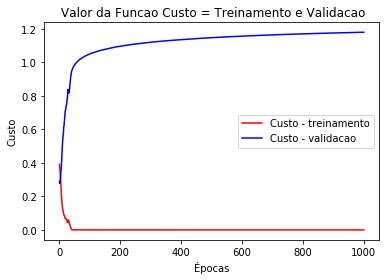

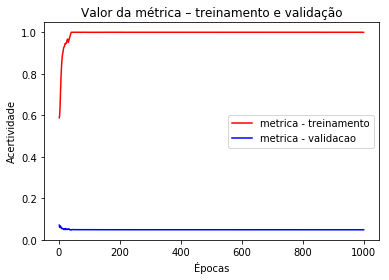

In [33]:
rna3.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna3.plot()

Confusion matrix, without normalization
[[25360  1625]
 [ 2017   998]]


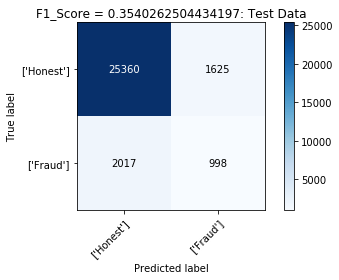

Confusion matrix, without normalization
[[25410  1576]
 [ 2035   980]]


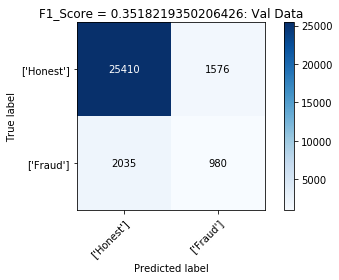

Confusion matrix, without normalization
[[125931      0]
 [     0  42204]]


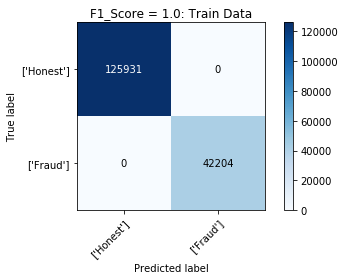

In [34]:
rna3.predict(x_data,y_data)

In [35]:
n_list4 = [50,50,50,1]
activation_list4 = ['tanh','tanh','tanh','sigmoid']

In [36]:
rna4 = new_rna()
rna4.build_model(data_shape,n_list4,activation_list4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 15,201
Trainable params: 15,201
Non-trainable params: 0
_________________________________________________________________


Train on 168135 samples, validate on 30001 samples
Epoch 1/1000
168135/168135 [==============================] - 7s 40us/step - loss: 0.3913 - f1: 0.5869 - val_loss: 0.2809 - val_f1: 0.0669
Epoch 2/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.3732 - f1: 0.6023 - val_loss: 0.2868 - val_f1: 0.0685
Epoch 3/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.3567 - f1: 0.6245 - val_loss: 0.2960 - val_f1: 0.0691
Epoch 4/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.3355 - f1: 0.6559 - val_loss: 0.2796 - val_f1: 0.0600
Epoch 5/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.3147 - f1: 0.6879 - val_loss: 0.3206 - val_f1: 0.0671
Epoch 6/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.2945 - f1: 0.7137 - val_loss: 0.3338 - val_f1: 0.0649
Epoch 7/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2766 - f1: 0.7350 - val_loss: 

168135/168135 [==============================] - 7s 39us/step - loss: 0.1302 - f1: 0.8908 - val_loss: 0.5362 - val_f1: 0.0560
Epoch 60/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.1287 - f1: 0.8925 - val_loss: 0.5487 - val_f1: 0.0548
Epoch 61/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.1284 - f1: 0.8914 - val_loss: 0.5472 - val_f1: 0.0553
Epoch 62/1000
168135/168135 [==============================] - 6s 39us/step - loss: 0.1285 - f1: 0.8911 - val_loss: 0.5502 - val_f1: 0.0523
Epoch 63/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.1267 - f1: 0.8942 - val_loss: 0.5581 - val_f1: 0.0536
Epoch 64/1000
168135/168135 [==============================] - 7s 39us/step - loss: 0.1275 - f1: 0.8928 - val_loss: 0.5501 - val_f1: 0.0552
Epoch 65/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.1275 - f1: 0.8955 - val_loss: 0.5528 - val_f1: 0.0559
Epoch 66/1000
168135/168135 [=====

168135/168135 [==============================] - 6s 38us/step - loss: 0.1077 - f1: 0.9128 - val_loss: 0.6227 - val_f1: 0.0533
Epoch 118/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.1093 - f1: 0.9110 - val_loss: 0.6236 - val_f1: 0.0535
Epoch 119/1000
168135/168135 [==============================] - 6s 39us/step - loss: 0.1083 - f1: 0.9110 - val_loss: 0.6182 - val_f1: 0.0536
Epoch 120/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.1075 - f1: 0.9131 - val_loss: 0.6305 - val_f1: 0.0538
Epoch 121/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.1058 - f1: 0.9151 - val_loss: 0.6254 - val_f1: 0.0533
Epoch 122/1000
168135/168135 [==============================] - 7s 39us/step - loss: 0.1050 - f1: 0.9155 - val_loss: 0.6367 - val_f1: 0.0543
Epoch 123/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.1076 - f1: 0.9125 - val_loss: 0.6276 - val_f1: 0.0558
Epoch 124/1000
168135/168135

168135/168135 [==============================] - 6s 37us/step - loss: 0.0998 - f1: 0.9186 - val_loss: 0.6653 - val_f1: 0.0539
Epoch 176/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0955 - f1: 0.9235 - val_loss: 0.6815 - val_f1: 0.0529
Epoch 177/1000
168135/168135 [==============================] - 6s 35us/step - loss: 0.0977 - f1: 0.9210 - val_loss: 0.6712 - val_f1: 0.0531
Epoch 178/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0988 - f1: 0.9194 - val_loss: 0.6727 - val_f1: 0.0511
Epoch 179/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0967 - f1: 0.9225 - val_loss: 0.6772 - val_f1: 0.0526
Epoch 180/1000
168135/168135 [==============================] - 7s 39us/step - loss: 0.0965 - f1: 0.9224 - val_loss: 0.6749 - val_f1: 0.0515
Epoch 181/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0972 - f1: 0.9228 - val_loss: 0.6754 - val_f1: 0.0520
Epoch 182/1000
168135/168135

168135/168135 [==============================] - 6s 39us/step - loss: 0.0909 - f1: 0.9268 - val_loss: 0.6969 - val_f1: 0.0524
Epoch 234/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0934 - f1: 0.9254 - val_loss: 0.6919 - val_f1: 0.0525
Epoch 235/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0935 - f1: 0.9273 - val_loss: 0.7005 - val_f1: 0.0519
Epoch 236/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0906 - f1: 0.9265 - val_loss: 0.7011 - val_f1: 0.0532
Epoch 237/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0917 - f1: 0.9263 - val_loss: 0.6984 - val_f1: 0.0504
Epoch 238/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0929 - f1: 0.9260 - val_loss: 0.6993 - val_f1: 0.0533
Epoch 239/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0913 - f1: 0.9276 - val_loss: 0.6900 - val_f1: 0.0533
Epoch 240/1000
168135/168135

168135/168135 [==============================] - 6s 37us/step - loss: 0.0892 - f1: 0.9288 - val_loss: 0.7132 - val_f1: 0.0550
Epoch 292/1000
168135/168135 [==============================] - 7s 40us/step - loss: 0.0898 - f1: 0.9295 - val_loss: 0.7084 - val_f1: 0.0533
Epoch 293/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0884 - f1: 0.9301 - val_loss: 0.7130 - val_f1: 0.0516
Epoch 294/1000
168135/168135 [==============================] - 7s 39us/step - loss: 0.0885 - f1: 0.9304 - val_loss: 0.7093 - val_f1: 0.0523
Epoch 295/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0884 - f1: 0.9299 - val_loss: 0.7109 - val_f1: 0.0530
Epoch 296/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0886 - f1: 0.9303 - val_loss: 0.7022 - val_f1: 0.0527
Epoch 297/1000
168135/168135 [==============================] - 7s 40us/step - loss: 0.0849 - f1: 0.9335 - val_loss: 0.7106 - val_f1: 0.0527
Epoch 298/1000
168135/168135

168135/168135 [==============================] - 6s 39us/step - loss: 0.0894 - f1: 0.9289 - val_loss: 0.7186 - val_f1: 0.0538
Epoch 350/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0879 - f1: 0.9311 - val_loss: 0.7122 - val_f1: 0.0520
Epoch 351/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0823 - f1: 0.9356 - val_loss: 0.7412 - val_f1: 0.0543
Epoch 352/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0836 - f1: 0.9338 - val_loss: 0.7299 - val_f1: 0.0525
Epoch 353/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0860 - f1: 0.9320 - val_loss: 0.7191 - val_f1: 0.0506
Epoch 354/1000
168135/168135 [==============================] - 6s 39us/step - loss: 0.0848 - f1: 0.9328 - val_loss: 0.7336 - val_f1: 0.0523
Epoch 355/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0848 - f1: 0.9338 - val_loss: 0.7228 - val_f1: 0.0515
Epoch 356/1000
168135/168135

168135/168135 [==============================] - 6s 37us/step - loss: 0.0883 - f1: 0.9301 - val_loss: 0.7349 - val_f1: 0.0536
Epoch 408/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0847 - f1: 0.9335 - val_loss: 0.7285 - val_f1: 0.0524
Epoch 409/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0815 - f1: 0.9357 - val_loss: 0.7335 - val_f1: 0.0520
Epoch 410/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0799 - f1: 0.9383 - val_loss: 0.7540 - val_f1: 0.0527
Epoch 411/1000
168135/168135 [==============================] - 6s 39us/step - loss: 0.0828 - f1: 0.9363 - val_loss: 0.7555 - val_f1: 0.0520
Epoch 412/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0853 - f1: 0.9331 - val_loss: 0.7339 - val_f1: 0.0535
Epoch 413/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0816 - f1: 0.9377 - val_loss: 0.7492 - val_f1: 0.0520
Epoch 414/1000
168135/168135

168135/168135 [==============================] - 6s 37us/step - loss: 0.0796 - f1: 0.9392 - val_loss: 0.7568 - val_f1: 0.0515
Epoch 466/1000
168135/168135 [==============================] - 7s 39us/step - loss: 0.0831 - f1: 0.9360 - val_loss: 0.7547 - val_f1: 0.0517
Epoch 467/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0778 - f1: 0.9414 - val_loss: 0.7718 - val_f1: 0.0520
Epoch 468/1000
168135/168135 [==============================] - 7s 39us/step - loss: 0.0837 - f1: 0.9352 - val_loss: 0.7510 - val_f1: 0.0535
Epoch 469/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0861 - f1: 0.9334 - val_loss: 0.7367 - val_f1: 0.0528
Epoch 470/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0788 - f1: 0.9399 - val_loss: 0.7650 - val_f1: 0.0534
Epoch 471/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0759 - f1: 0.9430 - val_loss: 0.7800 - val_f1: 0.0532
Epoch 472/1000
168135/168135

168135/168135 [==============================] - 6s 37us/step - loss: 0.0770 - f1: 0.9409 - val_loss: 0.7804 - val_f1: 0.0519
Epoch 524/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0828 - f1: 0.9357 - val_loss: 0.7689 - val_f1: 0.0536
Epoch 525/1000
168135/168135 [==============================] - 7s 40us/step - loss: 0.0828 - f1: 0.9364 - val_loss: 0.7577 - val_f1: 0.0529
Epoch 526/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0816 - f1: 0.9372 - val_loss: 0.7594 - val_f1: 0.0522
Epoch 527/1000
168135/168135 [==============================] - 7s 40us/step - loss: 0.0799 - f1: 0.9388 - val_loss: 0.7711 - val_f1: 0.0526
Epoch 528/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0789 - f1: 0.9398 - val_loss: 0.7618 - val_f1: 0.0522
Epoch 529/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0784 - f1: 0.9401 - val_loss: 0.7695 - val_f1: 0.0516
Epoch 530/1000
168135/168135

168135/168135 [==============================] - 7s 40us/step - loss: 0.0829 - f1: 0.9366 - val_loss: 0.7561 - val_f1: 0.0511
Epoch 582/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0779 - f1: 0.9397 - val_loss: 0.7763 - val_f1: 0.0534
Epoch 583/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0793 - f1: 0.9386 - val_loss: 0.7749 - val_f1: 0.0504
Epoch 584/1000
168135/168135 [==============================] - 7s 39us/step - loss: 0.0774 - f1: 0.9406 - val_loss: 0.7785 - val_f1: 0.0502
Epoch 585/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0757 - f1: 0.9417 - val_loss: 0.7816 - val_f1: 0.0513
Epoch 586/1000
168135/168135 [==============================] - 7s 39us/step - loss: 0.0743 - f1: 0.9437 - val_loss: 0.7911 - val_f1: 0.0506
Epoch 587/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0740 - f1: 0.9438 - val_loss: 0.8048 - val_f1: 0.0509
Epoch 588/1000
168135/168135

168135/168135 [==============================] - 6s 37us/step - loss: 0.0796 - f1: 0.9381 - val_loss: 0.7714 - val_f1: 0.0518
Epoch 640/1000
168135/168135 [==============================] - 7s 39us/step - loss: 0.0802 - f1: 0.9379 - val_loss: 0.7706 - val_f1: 0.0524
Epoch 641/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0741 - f1: 0.9439 - val_loss: 0.7934 - val_f1: 0.0511
Epoch 642/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0792 - f1: 0.9401 - val_loss: 0.7767 - val_f1: 0.0524
Epoch 643/1000
168135/168135 [==============================] - 7s 39us/step - loss: 0.0789 - f1: 0.9405 - val_loss: 0.7712 - val_f1: 0.0521
Epoch 644/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0761 - f1: 0.9423 - val_loss: 0.7945 - val_f1: 0.0513
Epoch 645/1000
168135/168135 [==============================] - 7s 39us/step - loss: 0.0845 - f1: 0.9348 - val_loss: 0.7612 - val_f1: 0.0532
Epoch 646/1000
168135/168135

168135/168135 [==============================] - 7s 39us/step - loss: 0.0787 - f1: 0.9395 - val_loss: 0.8016 - val_f1: 0.0514
Epoch 698/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0773 - f1: 0.9401 - val_loss: 0.7870 - val_f1: 0.0529
Epoch 699/1000
168135/168135 [==============================] - 7s 39us/step - loss: 0.0786 - f1: 0.9393 - val_loss: 0.7823 - val_f1: 0.0534
Epoch 700/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0761 - f1: 0.9402 - val_loss: 0.7967 - val_f1: 0.0526
Epoch 701/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0747 - f1: 0.9434 - val_loss: 0.8036 - val_f1: 0.0514
Epoch 702/1000
168135/168135 [==============================] - 7s 39us/step - loss: 0.0801 - f1: 0.9389 - val_loss: 0.7972 - val_f1: 0.0519
Epoch 703/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0773 - f1: 0.9414 - val_loss: 0.7904 - val_f1: 0.0526
Epoch 704/1000
168135/168135

168135/168135 [==============================] - 7s 39us/step - loss: 0.0741 - f1: 0.9432 - val_loss: 0.8222 - val_f1: 0.0520
Epoch 756/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0780 - f1: 0.9403 - val_loss: 0.8055 - val_f1: 0.0528
Epoch 757/1000
168135/168135 [==============================] - 7s 39us/step - loss: 0.0795 - f1: 0.9395 - val_loss: 0.8014 - val_f1: 0.0531
Epoch 758/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0774 - f1: 0.9396 - val_loss: 0.7941 - val_f1: 0.0514
Epoch 759/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0755 - f1: 0.9420 - val_loss: 0.8072 - val_f1: 0.0528
Epoch 760/1000
168135/168135 [==============================] - 6s 36us/step - loss: 0.0772 - f1: 0.9399 - val_loss: 0.7989 - val_f1: 0.0520
Epoch 761/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0794 - f1: 0.9391 - val_loss: 0.7990 - val_f1: 0.0536
Epoch 762/1000
168135/168135

168135/168135 [==============================] - 6s 38us/step - loss: 0.0761 - f1: 0.9421 - val_loss: 0.7968 - val_f1: 0.0517
Epoch 814/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0742 - f1: 0.9432 - val_loss: 0.7972 - val_f1: 0.0541
Epoch 815/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0791 - f1: 0.9399 - val_loss: 0.7759 - val_f1: 0.0529
Epoch 816/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0794 - f1: 0.9390 - val_loss: 0.7814 - val_f1: 0.0537
Epoch 817/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0756 - f1: 0.9425 - val_loss: 0.7930 - val_f1: 0.0530
Epoch 818/1000
168135/168135 [==============================] - 6s 37us/step - loss: 0.0769 - f1: 0.9417 - val_loss: 0.7840 - val_f1: 0.0539
Epoch 819/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0772 - f1: 0.9414 - val_loss: 0.7907 - val_f1: 0.0509
Epoch 820/1000
168135/168135

168135/168135 [==============================] - 8s 48us/step - loss: 0.0779 - f1: 0.9408 - val_loss: 0.7891 - val_f1: 0.0522
Epoch 872/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.0776 - f1: 0.9414 - val_loss: 0.7896 - val_f1: 0.0544
Epoch 873/1000
168135/168135 [==============================] - 7s 41us/step - loss: 0.0776 - f1: 0.9407 - val_loss: 0.7951 - val_f1: 0.0534
Epoch 874/1000
168135/168135 [==============================] - 7s 41us/step - loss: 0.0768 - f1: 0.9420 - val_loss: 0.7912 - val_f1: 0.0514
Epoch 875/1000
168135/168135 [==============================] - 7s 41us/step - loss: 0.0762 - f1: 0.9415 - val_loss: 0.7936 - val_f1: 0.0516
Epoch 876/1000
168135/168135 [==============================] - 7s 44us/step - loss: 0.0775 - f1: 0.9405 - val_loss: 0.7907 - val_f1: 0.0527
Epoch 877/1000
168135/168135 [==============================] - 7s 44us/step - loss: 0.0749 - f1: 0.9418 - val_loss: 0.7939 - val_f1: 0.0516
Epoch 878/1000
168135/168135

168135/168135 [==============================] - 6s 38us/step - loss: 0.0758 - f1: 0.9423 - val_loss: 0.7740 - val_f1: 0.0518
Epoch 930/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0737 - f1: 0.9441 - val_loss: 0.7879 - val_f1: 0.0517
Epoch 931/1000
168135/168135 [==============================] - 7s 41us/step - loss: 0.0744 - f1: 0.9446 - val_loss: 0.7899 - val_f1: 0.0517
Epoch 932/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0741 - f1: 0.9437 - val_loss: 0.8079 - val_f1: 0.0517
Epoch 933/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0764 - f1: 0.9416 - val_loss: 0.8095 - val_f1: 0.0517
Epoch 934/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0780 - f1: 0.9415 - val_loss: 0.7985 - val_f1: 0.0528
Epoch 935/1000
168135/168135 [==============================] - 6s 38us/step - loss: 0.0795 - f1: 0.9404 - val_loss: 0.7936 - val_f1: 0.0526
Epoch 936/1000
168135/168135

168135/168135 [==============================] - 7s 40us/step - loss: 0.0779 - f1: 0.9414 - val_loss: 0.7937 - val_f1: 0.0513
Epoch 988/1000
168135/168135 [==============================] - 7s 41us/step - loss: 0.0769 - f1: 0.9420 - val_loss: 0.7977 - val_f1: 0.0528
Epoch 989/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.0737 - f1: 0.9435 - val_loss: 0.8113 - val_f1: 0.0536
Epoch 990/1000
168135/168135 [==============================] - 7s 41us/step - loss: 0.0731 - f1: 0.9449 - val_loss: 0.8170 - val_f1: 0.0527
Epoch 991/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.0763 - f1: 0.9419 - val_loss: 0.8057 - val_f1: 0.0521
Epoch 992/1000
168135/168135 [==============================] - 7s 40us/step - loss: 0.0804 - f1: 0.9393 - val_loss: 0.7960 - val_f1: 0.0521
Epoch 993/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.0829 - f1: 0.9375 - val_loss: 0.7766 - val_f1: 0.0530
Epoch 994/1000
168135/168135

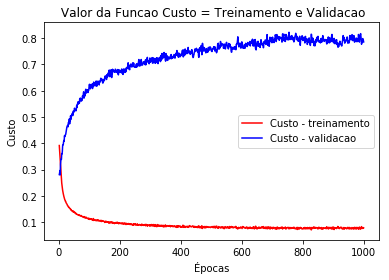

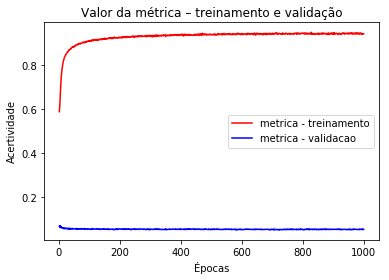

In [37]:
rna4.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna4.plot()

Confusion matrix, without normalization
[[24827  2158]
 [ 1953  1062]]


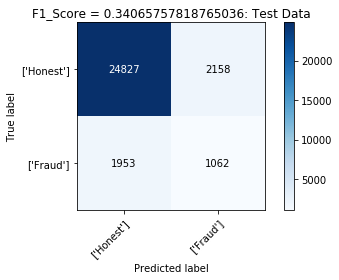

Confusion matrix, without normalization
[[24834  2152]
 [ 1942  1073]]


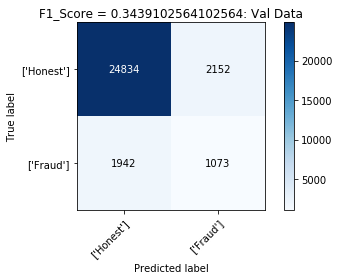

Confusion matrix, without normalization
[[123885   2046]
 [  1899  40305]]


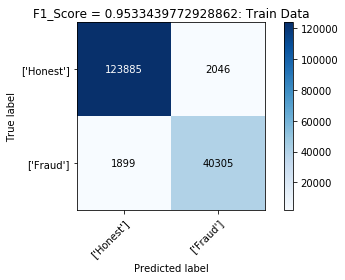

In [38]:
rna4.predict(x_data,y_data)

In [39]:
n_list5 = [100,100,100,1]
activation_list5 = ['tanh','tanh','tanh','sigmoid']

In [40]:
rna5 = new_rna()
rna5.build_model(data_shape,n_list5,activation_list5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 40,401
Trainable params: 40,401
Non-trainable params: 0
_________________________________________________________________


Train on 168135 samples, validate on 30001 samples
Epoch 1/1000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3925 - f1: 0.5860 - val_loss: 0.2901 - val_f1: 0.0697
Epoch 2/1000
168135/168135 [==============================] - 8s 45us/step - loss: 0.3763 - f1: 0.5945 - val_loss: 0.2790 - val_f1: 0.0671
Epoch 3/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.3581 - f1: 0.6181 - val_loss: 0.2970 - val_f1: 0.0684
Epoch 4/1000
168135/168135 [==============================] - 7s 44us/step - loss: 0.3307 - f1: 0.6582 - val_loss: 0.2985 - val_f1: 0.0656
Epoch 5/1000
168135/168135 [==============================] - 7s 44us/step - loss: 0.2950 - f1: 0.7088 - val_loss: 0.3346 - val_f1: 0.0653
Epoch 6/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.2567 - f1: 0.7588 - val_loss: 0.3499 - val_f1: 0.0643
Epoch 7/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2219 - f1: 0.7979 - val_loss: 

168135/168135 [==============================] - 8s 47us/step - loss: 0.0512 - f1: 0.9610 - val_loss: 0.8425 - val_f1: 0.0519
Epoch 60/1000
168135/168135 [==============================] - 8s 45us/step - loss: 0.0384 - f1: 0.9701 - val_loss: 0.8701 - val_f1: 0.0514
Epoch 61/1000
168135/168135 [==============================] - 8s 46us/step - loss: 0.0330 - f1: 0.9745 - val_loss: 0.8698 - val_f1: 0.0522
Epoch 62/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.0347 - f1: 0.9740 - val_loss: 0.8796 - val_f1: 0.0514
Epoch 63/1000
168135/168135 [==============================] - 7s 44us/step - loss: 0.0315 - f1: 0.9753 - val_loss: 0.8928 - val_f1: 0.0499
Epoch 64/1000
168135/168135 [==============================] - 8s 46us/step - loss: 0.0320 - f1: 0.9756 - val_loss: 0.9011 - val_f1: 0.0487
Epoch 65/1000
168135/168135 [==============================] - 7s 44us/step - loss: 0.0335 - f1: 0.9743 - val_loss: 0.9073 - val_f1: 0.0515
Epoch 66/1000
168135/168135 [=====

168135/168135 [==============================] - 8s 46us/step - loss: 4.1108e-04 - f1: 1.0000 - val_loss: 1.0485 - val_f1: 0.0480
Epoch 118/1000
168135/168135 [==============================] - 7s 41us/step - loss: 3.5202e-04 - f1: 1.0000 - val_loss: 1.0553 - val_f1: 0.0481
Epoch 119/1000
168135/168135 [==============================] - 7s 44us/step - loss: 3.0885e-04 - f1: 0.9998 - val_loss: 1.0613 - val_f1: 0.0482
Epoch 120/1000
168135/168135 [==============================] - 8s 46us/step - loss: 2.7582e-04 - f1: 1.0000 - val_loss: 1.0665 - val_f1: 0.0483
Epoch 121/1000
168135/168135 [==============================] - 8s 50us/step - loss: 2.4938e-04 - f1: 1.0000 - val_loss: 1.0713 - val_f1: 0.0483
Epoch 122/1000
168135/168135 [==============================] - 7s 39us/step - loss: 2.2776e-04 - f1: 1.0000 - val_loss: 1.0755 - val_f1: 0.0482
Epoch 123/1000
168135/168135 [==============================] - 8s 46us/step - loss: 2.0969e-04 - f1: 1.0000 - val_loss: 1.0796 - val_f1: 0.0483


168135/168135 [==============================] - 8s 45us/step - loss: 4.2687e-05 - f1: 1.0000 - val_loss: 1.1576 - val_f1: 0.0481
Epoch 174/1000
168135/168135 [==============================] - 8s 50us/step - loss: 4.2008e-05 - f1: 1.0000 - val_loss: 1.1585 - val_f1: 0.0481
Epoch 175/1000
168135/168135 [==============================] - 9s 52us/step - loss: 4.1350e-05 - f1: 0.9998 - val_loss: 1.1592 - val_f1: 0.0481
Epoch 176/1000
168135/168135 [==============================] - 8s 48us/step - loss: 4.0713e-05 - f1: 1.0000 - val_loss: 1.1599 - val_f1: 0.0481
Epoch 177/1000
168135/168135 [==============================] - 8s 47us/step - loss: 4.0093e-05 - f1: 1.0000 - val_loss: 1.1605 - val_f1: 0.0481
Epoch 178/1000
168135/168135 [==============================] - 9s 53us/step - loss: 3.9493e-05 - f1: 0.9998 - val_loss: 1.1613 - val_f1: 0.0481
Epoch 179/1000
168135/168135 [==============================] - 8s 46us/step - loss: 3.8910e-05 - f1: 0.9998 - val_loss: 1.1620 - val_f1: 0.0481


168135/168135 [==============================] - 8s 47us/step - loss: 2.2268e-05 - f1: 1.0000 - val_loss: 1.1873 - val_f1: 0.0483
Epoch 230/1000
168135/168135 [==============================] - 8s 45us/step - loss: 2.2078e-05 - f1: 1.0000 - val_loss: 1.1878 - val_f1: 0.0483
Epoch 231/1000
168135/168135 [==============================] - 8s 46us/step - loss: 2.1890e-05 - f1: 1.0000 - val_loss: 1.1882 - val_f1: 0.0483
Epoch 232/1000
168135/168135 [==============================] - 8s 46us/step - loss: 2.1706e-05 - f1: 1.0000 - val_loss: 1.1885 - val_f1: 0.0483
Epoch 233/1000
168135/168135 [==============================] - 8s 46us/step - loss: 2.1524e-05 - f1: 0.9998 - val_loss: 1.1888 - val_f1: 0.0483
Epoch 234/1000
168135/168135 [==============================] - 8s 45us/step - loss: 2.1346e-05 - f1: 0.9996 - val_loss: 1.1892 - val_f1: 0.0483
Epoch 235/1000
168135/168135 [==============================] - 8s 46us/step - loss: 2.1170e-05 - f1: 1.0000 - val_loss: 1.1897 - val_f1: 0.0483


168135/168135 [==============================] - 7s 43us/step - loss: 1.4975e-05 - f1: 0.9998 - val_loss: 1.2048 - val_f1: 0.0482
Epoch 286/1000
168135/168135 [==============================] - 7s 44us/step - loss: 1.4887e-05 - f1: 1.0000 - val_loss: 1.2050 - val_f1: 0.0482
Epoch 287/1000
168135/168135 [==============================] - 8s 46us/step - loss: 1.4801e-05 - f1: 1.0000 - val_loss: 1.2053 - val_f1: 0.0482
Epoch 288/1000
168135/168135 [==============================] - 8s 48us/step - loss: 1.4715e-05 - f1: 0.9998 - val_loss: 1.2054 - val_f1: 0.0482
Epoch 289/1000
168135/168135 [==============================] - 8s 45us/step - loss: 1.4631e-05 - f1: 1.0000 - val_loss: 1.2057 - val_f1: 0.0482
Epoch 290/1000
168135/168135 [==============================] - 8s 47us/step - loss: 1.4547e-05 - f1: 0.9998 - val_loss: 1.2061 - val_f1: 0.0483
Epoch 291/1000
168135/168135 [==============================] - 8s 45us/step - loss: 1.4465e-05 - f1: 1.0000 - val_loss: 1.2062 - val_f1: 0.0483


168135/168135 [==============================] - 7s 41us/step - loss: 1.1263e-05 - f1: 1.0000 - val_loss: 1.2167 - val_f1: 0.0483
Epoch 342/1000
168135/168135 [==============================] - 8s 46us/step - loss: 1.1213e-05 - f1: 1.0000 - val_loss: 1.2170 - val_f1: 0.0483
Epoch 343/1000
168135/168135 [==============================] - 8s 45us/step - loss: 1.1164e-05 - f1: 1.0000 - val_loss: 1.2171 - val_f1: 0.0483
Epoch 344/1000
168135/168135 [==============================] - 8s 47us/step - loss: 1.1115e-05 - f1: 1.0000 - val_loss: 1.2173 - val_f1: 0.0483
Epoch 345/1000
168135/168135 [==============================] - 7s 44us/step - loss: 1.1067e-05 - f1: 0.9998 - val_loss: 1.2175 - val_f1: 0.0484
Epoch 346/1000
168135/168135 [==============================] - 8s 45us/step - loss: 1.1019e-05 - f1: 1.0000 - val_loss: 1.2178 - val_f1: 0.0484
Epoch 347/1000
168135/168135 [==============================] - 7s 42us/step - loss: 1.0971e-05 - f1: 1.0000 - val_loss: 1.2178 - val_f1: 0.0484


168135/168135 [==============================] - 8s 46us/step - loss: 9.0298e-06 - f1: 0.9998 - val_loss: 1.2258 - val_f1: 0.0485
Epoch 398/1000
168135/168135 [==============================] - 8s 45us/step - loss: 8.9982e-06 - f1: 1.0000 - val_loss: 1.2261 - val_f1: 0.0485
Epoch 399/1000
168135/168135 [==============================] - 8s 47us/step - loss: 8.9667e-06 - f1: 0.9998 - val_loss: 1.2263 - val_f1: 0.0485
Epoch 400/1000
168135/168135 [==============================] - 8s 45us/step - loss: 8.9353e-06 - f1: 1.0000 - val_loss: 1.2264 - val_f1: 0.0485
Epoch 401/1000
168135/168135 [==============================] - 8s 48us/step - loss: 8.9043e-06 - f1: 1.0000 - val_loss: 1.2265 - val_f1: 0.0485
Epoch 402/1000
168135/168135 [==============================] - 9s 51us/step - loss: 8.8735e-06 - f1: 1.0000 - val_loss: 1.2268 - val_f1: 0.0485
Epoch 403/1000
168135/168135 [==============================] - 8s 48us/step - loss: 8.8429e-06 - f1: 1.0000 - val_loss: 1.2267 - val_f1: 0.0485


168135/168135 [==============================] - 8s 47us/step - loss: 7.5481e-06 - f1: 1.0000 - val_loss: 1.2331 - val_f1: 0.0484
Epoch 454/1000
168135/168135 [==============================] - 8s 46us/step - loss: 7.5262e-06 - f1: 1.0000 - val_loss: 1.2333 - val_f1: 0.0484
Epoch 455/1000
168135/168135 [==============================] - 8s 48us/step - loss: 7.5045e-06 - f1: 1.0000 - val_loss: 1.2334 - val_f1: 0.0484
Epoch 456/1000
168135/168135 [==============================] - 9s 52us/step - loss: 7.4828e-06 - f1: 1.0000 - val_loss: 1.2334 - val_f1: 0.0484
Epoch 457/1000
168135/168135 [==============================] - 8s 47us/step - loss: 7.4613e-06 - f1: 1.0000 - val_loss: 1.2337 - val_f1: 0.0484
Epoch 458/1000
168135/168135 [==============================] - 8s 46us/step - loss: 7.4400e-06 - f1: 1.0000 - val_loss: 1.2339 - val_f1: 0.0484
Epoch 459/1000
168135/168135 [==============================] - 8s 47us/step - loss: 7.4188e-06 - f1: 0.9994 - val_loss: 1.2339 - val_f1: 0.0484


168135/168135 [==============================] - 8s 48us/step - loss: 6.4997e-06 - f1: 1.0000 - val_loss: 1.2391 - val_f1: 0.0483
Epoch 510/1000
168135/168135 [==============================] - 8s 46us/step - loss: 6.4837e-06 - f1: 0.9996 - val_loss: 1.2392 - val_f1: 0.0483
Epoch 511/1000
168135/168135 [==============================] - 8s 45us/step - loss: 6.4681e-06 - f1: 1.0000 - val_loss: 1.2394 - val_f1: 0.0483
Epoch 512/1000
168135/168135 [==============================] - 8s 47us/step - loss: 6.4522e-06 - f1: 0.9998 - val_loss: 1.2394 - val_f1: 0.0483
Epoch 513/1000
168135/168135 [==============================] - 8s 45us/step - loss: 6.4366e-06 - f1: 0.9996 - val_loss: 1.2396 - val_f1: 0.0483
Epoch 514/1000
168135/168135 [==============================] - 8s 48us/step - loss: 6.4210e-06 - f1: 1.0000 - val_loss: 1.2396 - val_f1: 0.0483
Epoch 515/1000
168135/168135 [==============================] - 8s 46us/step - loss: 6.4055e-06 - f1: 0.9998 - val_loss: 1.2397 - val_f1: 0.0483


168135/168135 [==============================] - 8s 45us/step - loss: 5.7227e-06 - f1: 0.9996 - val_loss: 1.2442 - val_f1: 0.0483
Epoch 566/1000
168135/168135 [==============================] - 7s 44us/step - loss: 5.7106e-06 - f1: 1.0000 - val_loss: 1.2442 - val_f1: 0.0483
Epoch 567/1000
168135/168135 [==============================] - 8s 46us/step - loss: 5.6986e-06 - f1: 0.9994 - val_loss: 1.2444 - val_f1: 0.0483
Epoch 568/1000
168135/168135 [==============================] - 8s 47us/step - loss: 5.6868e-06 - f1: 1.0000 - val_loss: 1.2445 - val_f1: 0.0483
Epoch 569/1000
168135/168135 [==============================] - 8s 47us/step - loss: 5.6749e-06 - f1: 1.0000 - val_loss: 1.2446 - val_f1: 0.0483
Epoch 570/1000
168135/168135 [==============================] - 7s 44us/step - loss: 5.6632e-06 - f1: 0.9998 - val_loss: 1.2447 - val_f1: 0.0483
Epoch 571/1000
168135/168135 [==============================] - 8s 48us/step - loss: 5.6514e-06 - f1: 0.9998 - val_loss: 1.2446 - val_f1: 0.0483


168135/168135 [==============================] - 8s 47us/step - loss: 5.1267e-06 - f1: 1.0000 - val_loss: 1.2485 - val_f1: 0.0483
Epoch 622/1000
168135/168135 [==============================] - 8s 45us/step - loss: 5.1174e-06 - f1: 1.0000 - val_loss: 1.2486 - val_f1: 0.0483
Epoch 623/1000
168135/168135 [==============================] - 8s 47us/step - loss: 5.1080e-06 - f1: 1.0000 - val_loss: 1.2486 - val_f1: 0.0483
Epoch 624/1000
168135/168135 [==============================] - 8s 46us/step - loss: 5.0988e-06 - f1: 1.0000 - val_loss: 1.2485 - val_f1: 0.0483
Epoch 625/1000
168135/168135 [==============================] - 8s 47us/step - loss: 5.0895e-06 - f1: 1.0000 - val_loss: 1.2489 - val_f1: 0.0483
Epoch 626/1000
168135/168135 [==============================] - 8s 46us/step - loss: 5.0804e-06 - f1: 0.9998 - val_loss: 1.2487 - val_f1: 0.0483
Epoch 627/1000
168135/168135 [==============================] - 8s 47us/step - loss: 5.0711e-06 - f1: 1.0000 - val_loss: 1.2489 - val_f1: 0.0483


168135/168135 [==============================] - 8s 45us/step - loss: 4.6584e-06 - f1: 1.0000 - val_loss: 1.2522 - val_f1: 0.0483
Epoch 678/1000
168135/168135 [==============================] - 8s 48us/step - loss: 4.6512e-06 - f1: 1.0000 - val_loss: 1.2521 - val_f1: 0.0483
Epoch 679/1000
168135/168135 [==============================] - 8s 45us/step - loss: 4.6438e-06 - f1: 1.0000 - val_loss: 1.2523 - val_f1: 0.0483
Epoch 680/1000
168135/168135 [==============================] - 8s 47us/step - loss: 4.6364e-06 - f1: 0.9998 - val_loss: 1.2524 - val_f1: 0.0483
Epoch 681/1000
168135/168135 [==============================] - 8s 48us/step - loss: 4.6291e-06 - f1: 0.9998 - val_loss: 1.2523 - val_f1: 0.0483
Epoch 682/1000
168135/168135 [==============================] - 8s 50us/step - loss: 4.6219e-06 - f1: 1.0000 - val_loss: 1.2525 - val_f1: 0.0483
Epoch 683/1000
168135/168135 [==============================] - 8s 45us/step - loss: 4.6146e-06 - f1: 0.9998 - val_loss: 1.2525 - val_f1: 0.0483


168135/168135 [==============================] - 8s 47us/step - loss: 4.2858e-06 - f1: 1.0000 - val_loss: 1.2554 - val_f1: 0.0483
Epoch 734/1000
168135/168135 [==============================] - 8s 50us/step - loss: 4.2797e-06 - f1: 1.0000 - val_loss: 1.2553 - val_f1: 0.0483
Epoch 735/1000
168135/168135 [==============================] - 8s 48us/step - loss: 4.2737e-06 - f1: 1.0000 - val_loss: 1.2554 - val_f1: 0.0483
Epoch 736/1000
168135/168135 [==============================] - 8s 48us/step - loss: 4.2678e-06 - f1: 0.9998 - val_loss: 1.2555 - val_f1: 0.0483
Epoch 737/1000
168135/168135 [==============================] - 8s 46us/step - loss: 4.2619e-06 - f1: 1.0000 - val_loss: 1.2557 - val_f1: 0.0483
Epoch 738/1000
168135/168135 [==============================] - 8s 45us/step - loss: 4.2560e-06 - f1: 0.9998 - val_loss: 1.2556 - val_f1: 0.0483
Epoch 739/1000
168135/168135 [==============================] - 8s 48us/step - loss: 4.2501e-06 - f1: 0.9998 - val_loss: 1.2556 - val_f1: 0.0483


168135/168135 [==============================] - 8s 45us/step - loss: 3.9803e-06 - f1: 0.9998 - val_loss: 1.2580 - val_f1: 0.0483
Epoch 790/1000
168135/168135 [==============================] - 8s 47us/step - loss: 3.9752e-06 - f1: 0.9998 - val_loss: 1.2581 - val_f1: 0.0483
Epoch 791/1000
168135/168135 [==============================] - 7s 40us/step - loss: 3.9704e-06 - f1: 0.9998 - val_loss: 1.2581 - val_f1: 0.0483
Epoch 792/1000
168135/168135 [==============================] - 8s 46us/step - loss: 3.9656e-06 - f1: 0.9998 - val_loss: 1.2583 - val_f1: 0.0483
Epoch 793/1000
168135/168135 [==============================] - 8s 45us/step - loss: 3.9606e-06 - f1: 1.0000 - val_loss: 1.2583 - val_f1: 0.0483
Epoch 794/1000
168135/168135 [==============================] - 8s 47us/step - loss: 3.9559e-06 - f1: 1.0000 - val_loss: 1.2583 - val_f1: 0.0483
Epoch 795/1000
168135/168135 [==============================] - 8s 45us/step - loss: 3.9510e-06 - f1: 1.0000 - val_loss: 1.2584 - val_f1: 0.0483


168135/168135 [==============================] - 8s 46us/step - loss: 3.7283e-06 - f1: 1.0000 - val_loss: 1.2607 - val_f1: 0.0482
Epoch 846/1000
168135/168135 [==============================] - 8s 47us/step - loss: 3.7245e-06 - f1: 1.0000 - val_loss: 1.2606 - val_f1: 0.0482
Epoch 847/1000
168135/168135 [==============================] - 7s 42us/step - loss: 3.7204e-06 - f1: 0.9998 - val_loss: 1.2607 - val_f1: 0.0482
Epoch 848/1000
168135/168135 [==============================] - 8s 45us/step - loss: 3.7163e-06 - f1: 1.0000 - val_loss: 1.2608 - val_f1: 0.0482
Epoch 849/1000
168135/168135 [==============================] - 8s 46us/step - loss: 3.7122e-06 - f1: 1.0000 - val_loss: 1.2608 - val_f1: 0.0482
Epoch 850/1000
168135/168135 [==============================] - 8s 45us/step - loss: 3.7080e-06 - f1: 1.0000 - val_loss: 1.2610 - val_f1: 0.0482
Epoch 851/1000
168135/168135 [==============================] - 8s 47us/step - loss: 3.7040e-06 - f1: 0.9996 - val_loss: 1.2608 - val_f1: 0.0482


168135/168135 [==============================] - 8s 47us/step - loss: 3.5166e-06 - f1: 0.9998 - val_loss: 1.2629 - val_f1: 0.0482
Epoch 902/1000
168135/168135 [==============================] - 7s 44us/step - loss: 3.5132e-06 - f1: 1.0000 - val_loss: 1.2629 - val_f1: 0.0482
Epoch 903/1000
168135/168135 [==============================] - 8s 47us/step - loss: 3.5096e-06 - f1: 0.9998 - val_loss: 1.2629 - val_f1: 0.0482
Epoch 904/1000
168135/168135 [==============================] - 8s 45us/step - loss: 3.5062e-06 - f1: 1.0000 - val_loss: 1.2629 - val_f1: 0.0482
Epoch 905/1000
168135/168135 [==============================] - 8s 47us/step - loss: 3.5028e-06 - f1: 0.9998 - val_loss: 1.2631 - val_f1: 0.0482
Epoch 906/1000
168135/168135 [==============================] - 8s 46us/step - loss: 3.4994e-06 - f1: 1.0000 - val_loss: 1.2630 - val_f1: 0.0482
Epoch 907/1000
168135/168135 [==============================] - 8s 46us/step - loss: 3.4960e-06 - f1: 0.9998 - val_loss: 1.2630 - val_f1: 0.0482


168135/168135 [==============================] - 8s 47us/step - loss: 3.3359e-06 - f1: 1.0000 - val_loss: 1.2648 - val_f1: 0.0482
Epoch 958/1000
168135/168135 [==============================] - 8s 46us/step - loss: 3.3329e-06 - f1: 1.0000 - val_loss: 1.2648 - val_f1: 0.0482
Epoch 959/1000
168135/168135 [==============================] - 8s 47us/step - loss: 3.3299e-06 - f1: 0.9998 - val_loss: 1.2650 - val_f1: 0.0482
Epoch 960/1000
168135/168135 [==============================] - 8s 46us/step - loss: 3.3270e-06 - f1: 0.9998 - val_loss: 1.2650 - val_f1: 0.0482
Epoch 961/1000
168135/168135 [==============================] - 8s 48us/step - loss: 3.3239e-06 - f1: 0.9998 - val_loss: 1.2649 - val_f1: 0.0482
Epoch 962/1000
168135/168135 [==============================] - 8s 46us/step - loss: 3.3210e-06 - f1: 0.9996 - val_loss: 1.2650 - val_f1: 0.0482
Epoch 963/1000
168135/168135 [==============================] - 8s 47us/step - loss: 3.3181e-06 - f1: 1.0000 - val_loss: 1.2650 - val_f1: 0.0482


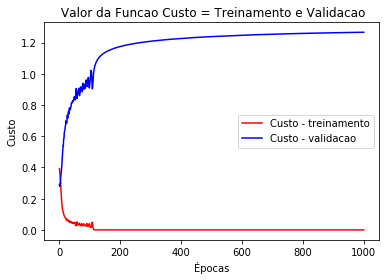

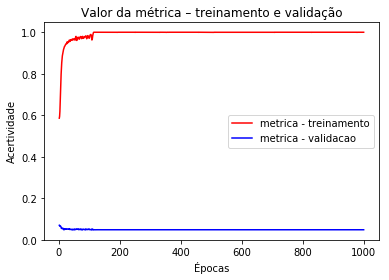

In [41]:
rna5.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna5.plot()

Confusion matrix, without normalization
[[25452  1533]
 [ 2089   926]]


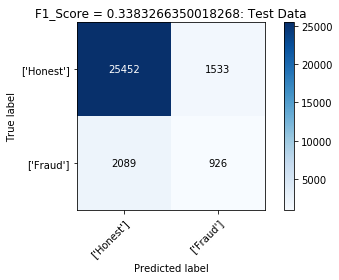

Confusion matrix, without normalization
[[25483  1503]
 [ 2052   963]]


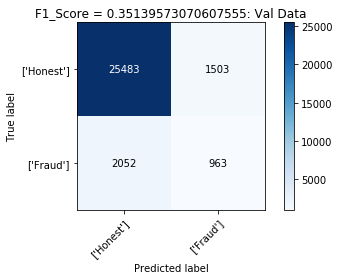

Confusion matrix, without normalization
[[125931      0]
 [     0  42204]]


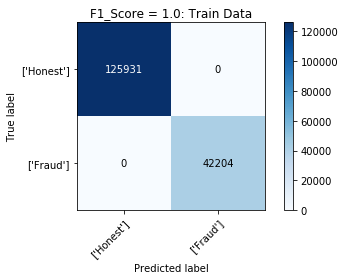

In [42]:
rna5.predict(x_data,y_data)